In [1]:
# -*- coding: utf-8 -*- 
%load_ext autoreload
%autoreload 2
%pylab inline
import itertools
import pandas as pd
from scipy.io import savemat, loadmat
import seaborn as sns
from sklearn.metrics import (log_loss, mean_squared_error, roc_curve, auc,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from BEMKL_multilabel import BEMKL_multilabel
from utils import poly_kernel, gauss_kernel, scoring

Populating the interactive namespace from numpy and matplotlib


 # load data

In [2]:
# load train/val/test splits
datasplits = loadmat('data/flower17/datasplits')
print(datasplits.keys())
# concatenate train/val-> train
train1 = np.append(datasplits['trn1'],datasplits['val1']) -1
test1  = np.squeeze(datasplits['tst1']) -1
total1 = np.append(train1,test1)
print(train1.shape,test1.shape,total1.shape)
print(train1[0:5])

dict_keys(['__header__', '__version__', '__globals__', 'trn1', 'trn2', 'trn3', 'tst1', 'tst2', 'tst3', 'val3', 'val2', 'val1'])
(1020,) (340,) (1360,)
[23 30  7 20 24]


In [3]:
# load 7 distance matrices
dist1 = loadmat('data/flower17/distancematrices17gcfeat06')
dist2 = loadmat('data/flower17/distancematrices17itfeat08')
print(dist1.keys())
print(dist2.keys())

dist_colour  = dist1['D_colourgc']
dist_texture = dist1['D_texturegc']
dist_shape   = dist1['D_shapegc']
dist_hog     = dist2['D_hog']
dist_hsv     = dist2['D_hsv']
dist_siftbdy = dist2['D_siftbdy']
dist_siftint = dist2['D_siftint']
names        = [dist_colour,dist_texture,dist_shape,dist_hog,dist_hsv,dist_siftbdy,dist_siftint]
print(dist_colour.shape)
print(dist_texture.shape)
print(dist_shape.shape)
print(dist_hog.shape)
print(dist_hsv.shape)
print(dist_siftbdy.shape)
print(dist_siftint.shape)

dict_keys(['__header__', '__version__', '__globals__', 'D_colourgc', 'D_texturegc', 'D_shapegc'])
dict_keys(['__header__', '__version__', '__globals__', 'D_hog', 'D_hsv', 'D_siftbdy', 'D_siftint'])
(1360, 1360)
(1360, 1360)
(1360, 1360)
(1360, 1360)
(1360, 1360)
(1360, 1360)
(1360, 1360)


# utils

In [4]:
def convertToOneHot(vector, num_classes=None):
    """
    Converts an input 1-D vector of integer labels into an output
    2-D array of one-hot vectors.

    Example:
        v         = np.array((1, 0, 4))
        one_hot_v = convertToOneHot(v)
        print one_hot_v

        [[0 1 0 0 0]
         [1 0 0 0 0]
         [0 0 0 0 1]]
    """

    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    if num_classes is None:
        num_classes = np.max(vector)+1
    else:
        assert num_classes > 0
        assert num_classes >= np.max(vector)

    result = np.ones(shape=(len(vector), num_classes))*-1
    result[np.arange(len(vector)), vector] = 1
    return result.astype(int)

In [5]:
def accuracy(trained_model, y_train, y_total):
    y_pred_proba = trained_model.predict_proba(np.zeros((340,1))) # predicted probabilities
    y_pred       = trained_model.predict(np.zeros((340,1)))       # predicted labels
    
    total = y_total[y_train.shape[0]:,:].T*y_pred
    total = total.sum(axis=0)
    print(total.shape)
    
    nb_correct = ((total==17).sum())
    acc=nb_correct/340 # accuracy
    
    return acc

In [6]:
def check_sparsity_one_split(train_idx, total_idx):
    
    acc=[]
    e_mu=[]
    a_mu=[]
    
    # create kernel matrices from distance matricces
    Km_train = np.zeros((7,len(train_idx),len(train_idx)))  
    Km_total = np.zeros((7,len(total_idx),len(total_idx))) 
    for idx, d in enumerate(names):
        dtrain = d[train1][:,train_idx] 
        dtotal = d[total1][:,total_idx]
        m      = np.mean(dtrain[0])
        Km_train[idx,:,:] = np.exp((-dtrain) / m)
        Km_total[idx,:,:] = np.exp((-dtotal) / m)
    
    # create one-hot true labels
    y = []
    for i in range(17):
        y.extend((np.ones(80)*i))
    y = np.asarray(y)
    y_train = y[train_idx]  
    print(y_train.shape)
    y_total = y[total_idx]  
    print(y_total.shape)
    y_train = convertToOneHot(y_train.astype(int))
    y_total = convertToOneHot(y_total.astype(int))
    
    # BEMKL multiclass train: SV uniform + kernel uniform
    sparse_model1 = BEMKL_multilabel(Km_train,Km_total, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1, e_null_thrsh=1e-3,
                     filter_kernels=False, filter_sv=False, verbose=10)
    normalizer       = Normalizer()
    sparse_pipeline1 = make_pipeline(normalizer, sparse_model1)
    sparse_pipeline1.fit(np.zeros((len(train_idx),1)), y_train.T)
    acc1 = accuracy(sparse_pipeline1, y_train, y_total); acc.append(acc1)
    e_mu1 = sparse_model1.b_e_mu[17:17+7, 0] ; e_mu.append(e_mu1)
    a_mu1 = sparse_model1.a_mu ; a_mu.append(a_mu1)
    
    # BEMKL multiclass train: SV uniform + kernel sparse
    sparse_model2 = BEMKL_multilabel(Km_train,Km_total, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1e-10, beta_omega=1e10, e_null_thrsh=1e-3,
                     filter_kernels=False, filter_sv=False, verbose=10)
    normalizer       = Normalizer()
    sparse_pipeline2 = make_pipeline(normalizer, sparse_model2)
    sparse_pipeline2.fit(np.zeros((len(train_idx),1)), y_train.T)
    acc2 = accuracy(sparse_pipeline2, y_train, y_total); acc.append(acc2)
    e_mu2 = sparse_model2.b_e_mu[17:17+7, 0] ; e_mu.append(e_mu2)
    a_mu2 = sparse_model2.a_mu ; a_mu.append(a_mu2)
    
    # BEMKL multiclass train: SV sparse + kernel uniform
    sparse_model3 = BEMKL_multilabel(Km_train,Km_total, alpha_lambda=1e-10, beta_lambda=1e10, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1, e_null_thrsh=1e-3,
                     filter_kernels=False, filter_sv=False, verbose=10)
    normalizer       = Normalizer()
    sparse_pipeline3 = make_pipeline(normalizer, sparse_model3)
    sparse_pipeline3.fit(np.zeros((len(train_idx),1)), y_train.T)
    acc3 = accuracy(sparse_pipeline3, y_train, y_total); acc.append(acc3)
    e_mu3 = sparse_model3.b_e_mu[17:17+7, 0] ; e_mu.append(e_mu3)
    a_mu3 = sparse_model3.a_mu ; a_mu.append(a_mu3)
       
    return acc, e_mu, a_mu

# train models with different priors on first data split

In [7]:
acc, e_mu, a_mu = check_sparsity_one_split(train1, total1)

(1020,)
(1360,)
N, P, L:  1020 7 17
INIT--------------------------------------------------------
lambda_beta  1.0
a_mu 0.5
a_sigma [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
G_mu [ 1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5
 -1.5 -1.5]
G_sigma 1.0
gamma_beta  1.0
omega_beta  1.0
b_e_mu 0.0
b_e_sigma 1.0
f_mu 1.5
f_sigma 1.0


KmKm 1130.36303435
a_sqrd_mu [ 1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25
  1.25  1.25  1.25  1.25  1.25]
G_sqrd_mu [ 3315.  3315.  3315.  3315.  3315.  3315.  3315.  3315.  3315.  3315.
  3315.  3315.  3315.  3315.  3315.  3315.  3315.]
KmtimesG_mu -3461.80248789
b_sqrd_mu 1.0
e_sqrd_mu 2.0
etimesb_mu 0.0

iter0-------------------------------
output : 1.63557358447
normalization: 0.737472804357
lambda_beta  0.615384615385
a_mu 3.07762206378
a_sigma [ 0.00553831  0.00553831  0.00553831  0.00553831  0.00553831  0.00553831
  0.00553831  0.00553831  0.00553831  0.00553831  0.0055383

output : 3.24734297155
normalization: 0.987690941699
lambda_beta  0.192199267648
a_mu 2.89459507227
a_sigma [ 0.00555494  0.00551602  0.00552559  0.00551788  0.00551817  0.00553121
  0.00551509  0.00551822  0.0055178   0.00551604  0.00551618  0.00551925
  0.00552058  0.00551699  0.00551872  0.00551694  0.00551627]
a_sqrd_mu [  8.38423557e+00   1.91853090e-02   5.69706427e-01   1.24028395e-01
   1.07911783e-01   8.56497009e-01   6.28564769e-03   8.50876732e-02
   1.29523266e-01   1.39004309e-02   2.00348011e-02   1.71048264e-01
   2.36658436e-01   3.12625562e-02   5.51784313e-02   4.33501047e-02
   2.92085922e-02]
G_mu [ 0.78524733 -1.49543213 -1.62377188 -1.51779073 -1.61356655 -1.7530602
 -1.11681893 -1.26471877 -1.52885166 -1.47156372 -1.55363283 -1.14269124
 -1.35400045 -0.75411316 -0.85224145 -1.42195661 -1.29843575]
G_sigma 0.00997645383139
G_sqrd_mu [ 1838.54711314  1843.12910951  1932.37199029  2001.19973256  1826.43442726
  1892.73993328  2062.17493548  1693.46991833  1991.8426

output : 3.72538146631
normalization: 0.996788638318
lambda_beta  0.194753106776
a_mu 2.8706254395
a_sigma [ 0.00555468  0.00551587  0.00552522  0.00551765  0.00551788  0.00553058
  0.00551504  0.00551785  0.00551736  0.00551588  0.00551607  0.0055191
  0.00552009  0.00551697  0.00551833  0.00551684  0.00551621]
a_sqrd_mu [  8.24604510e+00   1.61906345e-02   5.48159267e-01   1.15766979e-01
   9.86547350e-02   8.10431694e-01   6.37492940e-03   7.20390188e-02
   1.12609614e-01   1.22250280e-02   1.90131018e-02   1.68573676e-01
   2.15181523e-01   3.45423427e-02   4.85026472e-02   4.23415492e-02
   2.99483267e-02]
G_mu [ 0.7721914  -1.50225246 -1.6241082  -1.51543549 -1.60701132 -1.74187658
 -1.12303726 -1.27136674 -1.52045046 -1.46328798 -1.55762723 -1.14646382
 -1.34647464 -0.75417949 -0.86182926 -1.42376156 -1.30133344]
G_sigma 0.00996946718582
G_sqrd_mu [ 1839.26145644  1845.18423791  1935.03576313  2004.78699633  1827.63452043
  1895.96708759  2067.17730375  1694.75013036  1995.22834

output : 3.9939217215
normalization: 0.998622917023
lambda_beta  0.197445997155
a_mu 2.84614685781
a_sigma [ 0.00555444  0.00551576  0.00552485  0.00551743  0.00551763  0.00552997
  0.005515    0.00551753  0.00551701  0.00551578  0.00551598  0.00551898
  0.00551967  0.00551696  0.00551812  0.00551674  0.00551616]
a_sqrd_mu [  8.10610638e+00   1.37014173e-02   5.26882810e-01   1.07942668e-01
   9.03460882e-02   7.67070682e-01   6.48655923e-03   6.05367376e-02
   9.77714043e-02   1.07109778e-02   1.80190180e-02   1.65520390e-01
   1.96358346e-01   3.77260517e-02   4.33334259e-02   4.12273536e-02
   3.03758069e-02]
G_mu [ 0.75911744 -1.5081097  -1.62349343 -1.51235593 -1.60003165 -1.730597
 -1.12865963 -1.27745459 -1.51183975 -1.45431826 -1.56051292 -1.14945475
 -1.3390994  -0.75422639 -0.87014447 -1.42469089 -1.30390828]
G_sigma 0.00996576015919
G_sqrd_mu [ 1838.36995775  1845.53581162  1935.86603693  2006.37137031  1827.16136091
  1897.43854869  2070.271342    1694.51749926  1996.777056

output : 4.17084537905
normalization: 0.999240019879
lambda_beta  0.200190079675
a_mu 2.82169561376
a_sigma [ 0.00555421  0.00551565  0.00552449  0.00551723  0.00551741  0.00552937
  0.00551497  0.00551725  0.00551671  0.0055157   0.0055159   0.00551885
  0.00551929  0.00551696  0.00551794  0.00551664  0.0055161 ]
a_sqrd_mu [  7.96752035e+00   1.16566715e-02   5.05908037e-01   1.00807847e-01
   8.28676589e-02   7.26373181e-01   6.60112271e-03   5.06975089e-02
   8.49580683e-02   9.44477527e-03   1.70928335e-02   1.61907432e-01
   1.79315486e-01   4.07953165e-02   3.90142821e-02   4.00366990e-02
   3.05118179e-02]
G_mu [ 0.74617835 -1.51325124 -1.62225763 -1.50911622 -1.59300435 -1.7194319
 -1.13390702 -1.28283479 -1.50350391 -1.44530515 -1.56279966 -1.15186388
 -1.3318721  -0.75430154 -0.87769789 -1.42514031 -1.30642647]
G_sigma 0.00996339355884
G_sqrd_mu [ 1836.81455457  1845.14473322  1935.90351898  2007.04565707  1825.96585985
  1898.13916724  2072.47984591  1693.6411767   1997.5383

output : 4.29664891398
normalization: 0.999510771356
lambda_beta  0.202976731976
a_mu 2.79733986154
a_sigma [ 0.00555398  0.00551556  0.00552414  0.00551705  0.0055172   0.00552879
  0.00551494  0.005517    0.00551644  0.00551562  0.00551582  0.00551872
  0.00551894  0.00551695  0.00551778  0.00551654  0.00551605]
a_sqrd_mu [  7.83066428e+00   9.99836422e-03   4.85305638e-01   9.43753979e-02
   7.61532471e-02   6.88274554e-01   6.71548364e-03   4.23444627e-02
   7.38887596e-02   8.40472274e-03   1.62361210e-02   1.57929281e-01
   1.63764530e-01   4.37444160e-02   3.52974492e-02   3.87952770e-02
   3.03835339e-02]
G_mu [ 0.73338214 -1.51779799 -1.62056184 -1.5059031  -1.5860824  -1.70846788
 -1.13890186 -1.28753341 -1.4955349  -1.43643466 -1.56468612 -1.15385102
 -1.32482511 -0.75443575 -0.88470603 -1.42529073 -1.30897083]
G_sigma 0.00996172161855
G_sqrd_mu [ 1834.93249123  1844.35732082  1935.5258672   2007.21681584  1824.39664995
  1898.42909827  2074.16842022  1692.42940316  1997.882

output : 4.39016786995
normalization: 0.999650750817
lambda_beta  0.205804353167
a_mu 2.77308570771
a_sigma [ 0.00555375  0.00551549  0.00552379  0.00551689  0.00551701  0.00552824
  0.00551492  0.00551679  0.0055162   0.00551555  0.00551575  0.00551859
  0.00551861  0.00551695  0.00551764  0.00551645  0.00551599]
a_sqrd_mu [  7.69555810e+00   8.67257308e-03   4.65140097e-01   8.85948768e-02
   7.01273386e-02   6.52623432e-01   6.82816288e-03   3.52868489e-02
   6.43286140e-02   7.56542798e-03   1.54425653e-02   1.53731875e-01
   1.49540144e-01   4.65691191e-02   3.20535768e-02   3.75190767e-02
   3.00319447e-02]
G_mu [ 0.72072122 -1.52183678 -1.61850576 -1.50278586 -1.5793304  -1.69773539
 -1.14370919 -1.29159905 -1.48796033 -1.42778337 -1.56627123 -1.15551709
 -1.31797965 -0.7546456  -0.89128258 -1.42523804 -1.31155664]
G_sigma 0.00996045507084
G_sqrd_mu [ 1832.88010948  1843.33727293  1934.91153456  2007.08162362  1822.62007717
  1898.47966827  2075.50777388  1691.02505721  1997.981

output : 4.46171065196
normalization: 0.999731623058
lambda_beta  0.208679578026
a_mu 2.74887694034
a_sigma [ 0.00555354  0.00551542  0.00552344  0.00551674  0.00551684  0.00552771
  0.00551489  0.0055166   0.00551599  0.00551549  0.00551569  0.00551846
  0.00551831  0.00551695  0.00551751  0.00551637  0.00551594]
a_sqrd_mu [  7.56187797e+00   7.63326621e-03   4.45465123e-01   8.34008037e-02
   6.47169665e-02   6.19247321e-01   6.93812256e-03   2.93523455e-02
   5.60799149e-02   6.90291194e-03   1.47064505e-02   1.49421024e-01
   1.36522280e-01   4.92652617e-02   2.91994492e-02   3.62201253e-02
   2.94989387e-02]
G_mu [ 0.70817946 -1.52543122 -1.61615888 -1.49978907 -1.57277748 -1.68724265
 -1.1483676  -1.29507983 -1.48078658 -1.41938512 -1.56761583 -1.15693155
 -1.31134823 -0.7549379  -0.89749727 -1.42504101 -1.31417719]
G_sigma 0.00995944216233
G_sqrd_mu [ 1830.74061793  1842.17428439  1934.15804936  2006.74999627  1820.72774638
  1898.38500583  2076.59102668  1689.50535327  1997.928

output : 4.51753167326
normalization: 0.999782209818
lambda_beta  0.211609099862
a_mu 2.7246708959
a_sigma [ 0.00555332  0.00551536  0.00552311  0.00551661  0.00551668  0.00552721
  0.00551487  0.00551643  0.00551581  0.00551544  0.00551563  0.00551834
  0.00551802  0.00551696  0.00551739  0.00551628  0.00551588]
a_sqrd_mu [  7.42938481e+00   6.84118499e-03   4.26323495e-01   7.87282281e-02
   5.98559564e-02   5.87978596e-01   7.04456571e-03   2.43898299e-02
   4.89712486e-02   6.39486892e-03   1.40235100e-02   1.45074243e-01
   1.24612425e-01   5.18287260e-02   2.66751305e-02   3.49088324e-02
   2.88226554e-02]
G_mu [ 0.69574727 -1.52862913 -1.61357313 -1.4969187  -1.56643697 -1.67698906
 -1.1529021  -1.29801943 -1.47400945 -1.41125423 -1.5687628  -1.15814583
 -1.30493746 -0.7553131  -0.90339788 -1.42473992 -1.3168194 ]
G_sigma 0.00995859484873
G_sqrd_mu [ 1828.56314539  1840.92227076  1933.32377907  2006.28926932  1818.77485787
  1898.2017654   2077.47470926  1687.91629702  1997.7775

output : 4.5616985668
normalization: 0.99981576836
lambda_beta  0.214596443883
a_mu 2.70045254749
a_sigma [ 0.00555311  0.0055153   0.00552278  0.00551649  0.00551653  0.00552672
  0.00551485  0.00551629  0.00551565  0.00551539  0.00551557  0.00551821
  0.00551776  0.00551696  0.00551728  0.0055162   0.00551582]
a_sqrd_mu [  7.29799707e+00   6.26233887e-03   4.07747795e-01   7.45174792e-02
   5.54852260e-02   5.58661512e-01   7.14687751e-03   2.02672148e-02
   4.28523224e-02   6.02081104e-03   1.33904234e-02   1.40747928e-01
   1.13724184e-01   5.42557707e-02   2.44343532e-02   3.35947062e-02
   2.80363922e-02]
G_mu [ 0.68342232 -1.53146793 -1.61078923 -1.4941725  -1.56031408 -1.66697037
 -1.15733002 -1.30045714 -1.46761867 -1.40339532 -1.5697448  -1.15919971
 -1.29874989 -0.75576763 -0.90901971 -1.4243646  -1.31946921]
G_sigma 0.00995785838449
G_sqrd_mu [ 1826.37875506  1839.6157878   1932.44583522  2005.74341544  1816.79676959
  1897.96620505  2078.19605633  1686.28718302  1997.56366

output : 4.59699002361
normalization: 0.999839039587
lambda_beta  0.217643267561
a_mu 2.67622126125
a_sigma [ 0.0055529   0.00551526  0.00552246  0.00551638  0.0055164   0.00552626
  0.00551483  0.00551616  0.00551551  0.00551535  0.00551552  0.0055181
  0.00551752  0.00551696  0.00551717  0.00551612  0.00551577]
a_sqrd_mu [  7.16771314e+00   5.86693195e-03   3.89761436e-01   7.07152219e-02
   5.15521438e-02   5.31152997e-01   7.24459685e-03   1.68688321e-02
   3.75911294e-02   5.76215106e-03   1.28043518e-02   1.36482320e-01
   1.03779055e-01   5.65433602e-02   2.24398407e-02   3.22864830e-02
   2.71686577e-02]
G_mu [ 0.67120554 -1.53397819 -1.60784011 -1.49154458 -1.5544095  -1.65718085
 -1.1616638  -1.30242853 -1.46160032 -1.39580786 -1.57058786 -1.1601249
 -1.29278527 -0.75629553 -0.91439019 -1.4239383  -1.32211346]
G_sigma 0.00995719702878
G_sqrd_mu [ 1824.20786183  1838.27802739  1931.54881664  2005.14251388  1814.81710925
  1897.70256957  2078.78124907  1684.63755214  1997.30991

output : 4.62537376448
normalization: 0.99985572809
lambda_beta  0.220750275094
a_mu 2.65198337716
a_sigma [ 0.00555269  0.00551522  0.00552214  0.00551627  0.00551628  0.00552581
  0.00551481  0.00551605  0.00551539  0.00551531  0.00551548  0.00551798
  0.0055173   0.00551696  0.00551708  0.00551605  0.00551571]
a_sqrd_mu [  7.03856852e+00   5.62865513e-03   3.72379839e-01   6.72742597e-02
   4.80097818e-02   5.05321715e-01   7.33739514e-03   1.40932105e-02
   3.30719300e-02   5.60220744e-03   1.22626814e-02   1.32305376e-01
   9.47044323e-02   5.86893420e-02   2.06607477e-02   3.09920953e-02
   2.62435640e-02]
G_mu [ 0.65909898 -1.5361858  -1.60475302 -1.48902748 -1.54872109 -1.64761422
 -1.16591263 -1.30396617 -1.45593837 -1.38848847 -1.57131326 -1.1609472
 -1.28704132 -0.75688937 -0.91953131 -1.4234797  -1.32474063]
G_sigma 0.00995658663723
G_sqrd_mu [ 1822.06419639  1836.9251175   1930.64950009  2004.50786537  1812.85213198
  1897.42758476  2079.2497294   1682.98091138  1997.03192

output : 4.64828106001
normalization: 0.999867999629
lambda_beta  0.22391760236
a_mu 2.6277489978
a_sigma [ 0.00555248  0.00551518  0.00552184  0.00551618  0.00551617  0.00552539
  0.0055148   0.00551595  0.00551529  0.00551527  0.00551543  0.00551787
  0.0055171   0.00551697  0.00551699  0.00551598  0.00551566]
a_sqrd_mu [  6.91061727e+00   5.52419930e-03   3.55611648e-01   6.41529682e-02
   4.48162806e-02   4.81046981e-01   7.42506376e-03   1.18512847e-02
   2.91935202e-02   5.52615037e-03   1.17629024e-02   1.28235919e-01
   8.64325875e-02   6.06925132e-02   1.90711074e-02   2.97185827e-02
   2.52813038e-02]
G_mu [ 0.64710485 -1.53811337 -1.60155091 -1.48661319 -1.54324499 -1.63826407
 -1.17008338 -1.30510013 -1.45061572 -1.38143206 -1.57193877 -1.16168782
 -1.28151433 -0.75754099 -0.9244611  -1.42300418 -1.32734091]
G_sigma 0.00995601051129
G_sqrd_mu [ 1819.95712407  1835.56859073  1929.75955431  2003.85497047  1810.91325015
  1897.15304191  2079.61658936  1681.32683975  1996.74064

output : 4.66677437582
normalization: 0.999877185329
lambda_beta  0.227144996455
a_mu 2.60353042395
a_sigma [ 0.00555226  0.00551515  0.00552154  0.0055161   0.00551607  0.00552498
  0.00551478  0.00551587  0.0055152   0.00551524  0.00551539  0.00551776
  0.00551691  0.00551697  0.0055169   0.00551591  0.00551561]
a_sqrd_mu [  6.78392293e+00   5.53289189e-03   3.39459833e-01   6.13146853e-02
   4.19343018e-02   4.58217650e-01   7.50750168e-03   1.00649089e-02
   2.58676558e-02   5.52090492e-03   1.13025682e-02   1.24286135e-01
   7.89001120e-02   6.25526132e-02   1.76487782e-02   2.84720473e-02
   2.42986212e-02]
G_mu [ 0.6352251  -1.53978105 -1.59825334 -1.4842937  -1.53797624 -1.62912411
 -1.17418125 -1.30585831 -1.44561483 -1.37463257 -1.57247938 -1.16236439
 -1.27619951 -0.75824183 -0.92919458 -1.42252447 -1.32990622]
G_sigma 0.00995545692322
G_sqrd_mu [ 1817.89305691  1834.21687955  1928.88718361  2003.19532787  1809.00855124
  1896.8873786   2079.89401418  1679.68227351  1996.443

output : 4.68165479608
normalization: 0.999884137486
lambda_beta  0.230431918988
a_mu 2.57934119227
a_sigma [ 0.00555205  0.00551513  0.00552125  0.00551602  0.00551597  0.00552459
  0.00551477  0.00551579  0.00551512  0.00551521  0.00551535  0.00551766
  0.00551674  0.00551697  0.00551682  0.00551584  0.00551556]
a_sqrd_mu [  6.65855304e+00   5.63640493e-03   3.23922760e-01   5.87271212e-02
   3.93305466e-02   4.36731232e-01   7.58470327e-03   8.66559378e-03
   2.30175887e-02   5.57502637e-03   1.08792935e-02   1.20463437e-01
   7.20476141e-02   6.42702610e-02   1.63747011e-02   2.72576237e-02
   2.33092556e-02]
G_mu [ 0.62346123 -1.5412071  -1.59487711 -1.48206127 -1.53290919 -1.6201882
 -1.17821021 -1.30626671 -1.44091821 -1.36808333 -1.5729479  -1.16299151
 -1.27109128 -0.75898323 -0.93374441 -1.42205121 -1.33243001]
G_sigma 0.00995491756488
G_sqrd_mu [ 1815.87634799  1832.87626351  1928.03820635  2002.53761227  1807.14378417
  1896.63668563  2080.09213552  1678.05231068  1996.1471

output : 4.69353369758
normalization: 0.999889420406
lambda_beta  0.233777618683
a_mu 2.5551954284
a_sigma [ 0.00555184  0.0055151   0.00552097  0.00551595  0.00551589  0.00552422
  0.00551476  0.00551573  0.00551505  0.00551518  0.00551531  0.00551756
  0.00551658  0.00551697  0.00551675  0.00551578  0.00551551]
a_sqrd_mu [  6.53457552e+00   5.81850911e-03   3.08995079e-01   5.63618545e-02
   3.69753532e-02   4.16493139e-01   7.65674612e-03   7.59340399e-03
   2.05767213e-02   5.67856202e-03   1.04907615e-02   1.16771854e-01
   6.58195064e-02   6.58468721e-02   1.52323318e-02   2.60794968e-02
   2.23243477e-02]
G_mu [ 0.61181416 -1.54240826 -1.59143683 -1.47990854 -1.52803784 -1.61145041
 -1.18217329 -1.30634963 -1.43650873 -1.36177733 -1.57335535 -1.16358128
 -1.26618352 -0.7597566  -0.93812135 -1.4215933  -1.33490717]
G_sigma 0.00995438653641
G_sqrd_mu [ 1813.90990349  1831.55149696  1927.21672831  2001.88844306  1805.32299597
  1896.40536566  2080.21958845  1676.4407348   1995.8544

output : 4.70288215986
normalization: 0.999893418045
lambda_beta  0.23718118293
a_mu 2.53110738634
a_sigma [ 0.00555163  0.00551508  0.0055207   0.00551588  0.00551581  0.00552386
  0.00551474  0.00551567  0.00551498  0.00551516  0.00551528  0.00551746
  0.00551643  0.00551697  0.00551668  0.00551572  0.00551546]
a_sqrd_mu [  6.41205623e+00   6.06485941e-03   2.94668497e-01   5.41938685e-02
   3.48423143e-02   3.97416042e-01   7.72377704e-03   6.79598642e-03
   1.84873796e-02   5.82290782e-03   1.01347341e-02   1.13212991e-01
   6.01638600e-02   6.72845827e-02   1.42072177e-02   2.49409423e-02
   2.13528096e-02]
G_mu [ 0.60028429 -1.54340004 -1.58794526 -1.47782869 -1.52335604 -1.60290506
 -1.18607281 -1.30612978 -1.43236979 -1.35570739 -1.57371128 -1.16414358
 -1.26146968 -0.76055355 -0.94233471 -1.42115813 -1.33733381]
G_sigma 0.00995385966604
G_sqrd_mu [ 1811.99557808  1830.24622823  1926.42563519  2001.25291492  1803.54897832
  1896.19658465  2080.28388112  1674.8503706   1995.5687

output : 4.71006598515
normalization: 0.999896397383
lambda_beta  0.240641578068
a_mu 2.50709111618
a_sigma [ 0.00555142  0.00551506  0.00552044  0.00551582  0.00551574  0.00552352
  0.00551473  0.00551562  0.00551493  0.00551514  0.00551525  0.00551737
  0.0055163   0.00551696  0.00551662  0.00551567  0.00551542]
a_sqrd_mu [  6.29105728e+00   6.36280770e-03   2.80932439e-01   5.22011627e-02
   3.29079322e-02   3.79419278e-01   7.78600212e-03   6.22769878e-03
   1.66997035e-02   6.00066697e-03   9.80906253e-03   1.09786703e-01
   5.50322665e-02   6.85861730e-02   1.32866557e-02   2.38443845e-02
   2.04016581e-02]
G_mu [ 0.58887145 -1.54419689 -1.58441362 -1.47581538 -1.5188576  -1.59454666
 -1.1899106  -1.30562843 -1.42848543 -1.34986623 -1.57402397 -1.16468638
 -1.25694295 -0.76136595 -0.94639253 -1.42075182 -1.3397071 ]
G_sigma 0.00995333404164
G_sqrd_mu [ 1810.13445326  1828.96328154  1925.66691258  2000.63497157  1801.82357166
  1896.01259822  2080.29163691  1673.283323    1995.292

output : 4.71537094738
normalization: 0.999898547098
lambda_beta  0.244157688626
a_mu 2.48316017413
a_sigma [ 0.0055512   0.00551505  0.00552019  0.00551576  0.00551567  0.00552319
  0.00551472  0.00551558  0.00551488  0.00551512  0.00551522  0.00551729
  0.00551617  0.00551696  0.00551656  0.00551561  0.00551537]
a_sqrd_mu [  6.17163565e+00   6.70123441e-03   2.67774580e-01   5.03643870e-02
   3.11513131e-02   3.62428407e-01   7.84367279e-03   5.84883449e-03
   1.51706618e-02   6.20551346e-03   9.51169621e-03   1.06491565e-01
   5.03797042e-02   6.97549841e-02   1.24594220e-02   2.27914834e-02
   1.94763042e-02]
G_mu [ 0.57757498 -1.54481235 -1.58085186 -1.47386285 -1.51453646 -1.58636996
 -1.19368809 -1.30486551 -1.42484047 -1.34424656 -1.57430064 -1.16521597
 -1.25259634 -0.76218602 -0.95030192 -1.42037938 -1.34202516]
G_sigma 0.00995280768194
G_sqrd_mu [ 1808.32705219  1827.70487715  1924.94188184  2000.03767611  1800.14788614
  1895.85495781  2080.24876676  1671.74115326  1995.025

output : 4.7190214383
normalization: 0.999900001961
lambda_beta  0.247728347121
a_mu 2.45932740887
a_sigma [ 0.00555099  0.00551503  0.00551994  0.00551571  0.00551561  0.00552288
  0.00551471  0.00551554  0.00551484  0.0055151   0.00551519  0.0055172
  0.00551606  0.00551696  0.0055165   0.00551556  0.00551533]
a_sqrd_mu [  6.05384229e+00   7.07039912e-03   2.55181265e-01   4.86665463e-02
   2.95538844e-02   3.46374716e-01   7.89707461e-03   5.62493099e-03
   1.38631648e-02   6.43206439e-03   9.24068782e-03   1.03325206e-01
   4.61643969e-02   7.07948558e-02   1.17155692e-02   2.17832130e-02
   1.85808196e-02]
G_mu [ 0.56639376 -1.54525915 -1.57726884 -1.47196584 -1.51038669 -1.57836988
 -1.19740646 -1.3038597  -1.42142047 -1.33884115 -1.57454759 -1.16573717
 -1.2484228  -0.76300631 -0.9540692  -1.42004481 -1.34428688]
G_sigma 0.00995227930269
G_sqrd_mu [ 1806.57347599  1826.47276376  1924.25137485  1999.46339865  1798.52246921
  1895.72468769  2080.16058745  1670.22500242  1994.77128

output : 4.72119445767
normalization: 0.999900858663
lambda_beta  0.251352363299
a_mu 2.4356048151
a_sigma [ 0.00555077  0.00551502  0.00551971  0.00551566  0.00551556  0.00552257
  0.0055147   0.0055155   0.00551481  0.00551509  0.00551517  0.00551712
  0.00551596  0.00551695  0.00551645  0.00551551  0.00551529]
a_sqrd_mu [  5.93772159e+00   7.46180491e-03   2.43137875e-01   4.70927072e-02
   2.80991451e-02   3.31194803e-01   7.94651338e-03   5.52615620e-03
   1.27452936e-02   6.67576474e-03   8.99419460e-03   1.00284519e-01
   4.23476662e-02   7.17100484e-02   1.10462544e-02   2.08199577e-02
   1.77181562e-02]
G_mu [ 0.55532626 -1.54554932 -1.57367251 -1.47011965 -1.50640261 -1.57054158
 -1.20106668 -1.30262854 -1.41821176 -1.3336428  -1.57477032 -1.16625346
 -1.24441524 -0.76381977 -0.95770002 -1.41975125 -1.34649179]
G_sigma 0.00995174814815
G_sqrd_mu [ 1804.87351127  1825.26832694  1923.59585101  1998.91397524  1796.94742306
  1895.62240718  2080.03191394  1668.73567146  1994.5289

output : 4.72203016387
normalization: 0.999901186296
lambda_beta  0.255028548745
a_mu 2.41200339988
a_sigma [ 0.00555056  0.00551501  0.00551948  0.00551562  0.0055155   0.00552229
  0.0055147   0.00551547  0.00551478  0.00551507  0.00551514  0.00551705
  0.00551587  0.00551694  0.0055164   0.00551547  0.00551526]
a_sqrd_mu [  5.82331096e+00   7.86807823e-03   2.31629094e-01   4.56297682e-02
   2.67724349e-02   3.16830191e-01   7.99230742e-03   5.52676332e-03
   1.17896084e-02   6.93277821e-03   8.77048036e-03   9.73658547e-02
   3.88937753e-02   7.25051865e-02   1.04436079e-02   1.99015951e-02
   1.68903463e-02]
G_mu [ 0.54437057 -1.54569425 -1.57007004 -1.46832003 -1.50257873 -1.56288037
 -1.20466959 -1.30118848 -1.41520143 -1.32864443 -1.57497362 -1.16676723
 -1.24056664 -0.76461972 -0.96119954 -1.41950104 -1.34863996]
G_sigma 0.00995121386841
G_sqrd_mu [ 1803.22670667  1824.09266824  1922.97549249  1998.3908065   1795.4225075
  1895.54840287  2079.86711869  1667.27370516  1994.2993

output : 4.72163994105
normalization: 0.999901033439
lambda_beta  0.258755742272
a_mu 2.38853307635
a_sigma [ 0.00555034  0.005515    0.00551926  0.00551558  0.00551546  0.00552201
  0.00551469  0.00551544  0.00551475  0.00551506  0.00551512  0.00551697
  0.00551578  0.00551693  0.00551635  0.00551543  0.00551522]
a_sqrd_mu [  5.71064060e+00   8.28285752e-03   2.20639128e-01   4.42662165e-02
   2.55607308e-02   3.03226976e-01   8.03478018e-03   5.60461015e-03
   1.09725471e-02   7.19989203e-03   8.56791429e-03   9.45651413e-02
   3.57697754e-02   7.31851868e-02   9.90062508e-03   1.90275871e-02
   1.60986670e-02]
G_mu [ 0.53352449 -1.54570477 -1.56646794 -1.46656324 -1.49890983 -1.55538176
 -1.20821596 -1.29955499 -1.4123773  -1.32383907 -1.57516169 -1.16727986
 -1.23687004 -0.7653999  -0.96457246 -1.4192958  -1.35073193]
G_sigma 0.00995067642884
G_sqrd_mu [ 1801.6324343   1822.9466698   1922.39026803  1997.8949411   1793.94720402
  1895.50271675  2079.6701935   1665.83942328  1994.082

output : 4.72011261021
normalization: 0.999900433015
lambda_beta  0.262532834006
a_mu 2.36520258572
a_sigma [ 0.00555013  0.00551499  0.00551905  0.00551554  0.00551541  0.00552175
  0.00551468  0.00551542  0.00551472  0.00551504  0.0055151   0.0055169
  0.0055157   0.00551692  0.00551631  0.00551538  0.00551519]
a_sqrd_mu [ 5.5997334   0.00870069  0.21015189  0.04299196  0.02445247  0.29033546
  0.00807425  0.00574073  0.01027391  0.00747443  0.00838497  0.091878
  0.03294534  0.0737552   0.00941108  0.01819706  0.01534379]
G_mu [ 0.52278553 -1.54559115 -1.56287212 -1.46484594 -1.49539094 -1.54804143
 -1.2117065  -1.29774259 -1.4097279  -1.31921985 -1.57533817 -1.16779193
 -1.23331862 -0.76615439 -0.96782306 -1.41913651 -1.35276852]
G_sigma 0.00995013604207
G_sqrd_mu [ 1800.08993428  1821.83102355  1921.83998828  1997.42714375  1792.52078123
  1895.4851945   2079.44478831  1664.43298004  1993.8794167   1735.13806578
  1804.74919436  1713.93890822  1729.87655449  1864.87276234  1975.15

output : 4.71698760606
normalization: 0.999899193835
lambda_beta  0.267001129021
a_mu 2.33817038417
a_sigma [ 0.00554987  0.00551498  0.00551882  0.00551549  0.00551536  0.00552145
  0.00551467  0.00551539  0.0055147   0.00551503  0.00551507  0.00551682
  0.00551562  0.00551691  0.00551626  0.00551534  0.00551515]
a_sqrd_mu [ 5.47259062  0.00918589  0.19853043  0.04160641  0.02327659  0.27613398
  0.00811692  0.00595179  0.00958554  0.00780118  0.00819444  0.08888039
  0.02999175  0.07428831  0.00890014  0.01728153  0.01450982]
G_mu [ 0.51038849 -1.54531471 -1.55869216 -1.46288848 -1.49146887 -1.53967227
 -1.21570915 -1.29542021 -1.40684339 -1.31405711 -1.57553361 -1.16838847
 -1.22934989 -0.76699482 -0.97146613 -1.41900922 -1.35507608]
G_sigma 0.00994950241844
G_sqrd_mu [ 1798.35462808  1820.56852036  1921.2417374   1996.91756032  1790.91719637
  1895.49991949  2079.15025577  1662.82731524  1993.65880026  1733.3454207
  1803.60623441  1712.5333939   1729.20729478  1863.47324105  1974.

output : 4.71250035121
normalization: 0.999897389112
lambda_beta  0.271534450037
a_mu 2.31134848816
a_sigma [ 0.00554962  0.00551498  0.00551859  0.00551545  0.00551532  0.00552117
  0.00551466  0.00551536  0.00551468  0.00551502  0.00551505  0.00551675
  0.00551554  0.00551689  0.00551621  0.0055153   0.00551511]
a_sqrd_mu [ 5.34788145  0.00966288  0.18754514  0.04031812  0.02221319  0.26277245
  0.00815639  0.00619885  0.00901165  0.00813219  0.00802659  0.08602354
  0.0273678   0.0746876   0.00844672  0.01642149  0.01372581]
G_mu [ 0.49812885 -1.54489735 -1.55453598 -1.4609768  -1.48773743 -1.53150664
 -1.21963783 -1.29289326 -1.40416594 -1.30912825 -1.57572187 -1.16898303
 -1.22555936 -0.76778467 -0.97495392 -1.41894467 -1.3573119 ]
G_sigma 0.0099488662505
G_sqrd_mu [ 1796.6871036   1819.34871483  1920.68996746  1996.4474051   1789.37728311
  1895.55182563  2078.82632385  1661.25935639  1993.45610074  1731.61668741
  1802.51015442  1711.17682688  1728.57082142  1862.11372631  1974.

output : 4.70672024659
normalization: 0.999895019676
lambda_beta  0.276131527086
a_mu 2.2847443188
a_sigma [ 0.00554936  0.00551497  0.00551838  0.00551541  0.00551528  0.00552091
  0.00551466  0.00551534  0.00551466  0.00551501  0.00551503  0.00551667
  0.00551548  0.00551688  0.00551617  0.00551526  0.00551508]
a_sqrd_mu [ 5.22560596  0.01012674  0.17717008  0.03911656  0.02124976  0.25019037
  0.00819309  0.00646444  0.00853287  0.00846522  0.00787951  0.08329979
  0.02503718  0.07496178  0.00804414  0.01561456  0.01299084]
G_mu [ 0.48600161 -1.54435302 -1.55041074 -1.45910751 -1.48418992 -1.52353855
 -1.2234936  -1.29018076 -1.40168058 -1.3044232  -1.57590657 -1.16957383
 -1.2219371  -0.76851648 -0.97829175 -1.41894169 -1.35947833]
G_sigma 0.00994822865646
G_sqrd_mu [ 1795.08575118  1818.17206007  1920.18390148  1996.01687642  1787.8992377
  1895.64001509  2078.47736186  1659.72873964  1993.27116363  1729.94956178
  1801.45973551  1709.86922108  1727.96641868  1860.79371688  1973.9

output : 4.69970139337
normalization: 0.999892073354
lambda_beta  0.280791343337
a_mu 2.25836294131
a_sigma [ 0.0055491   0.00551496  0.00551818  0.00551538  0.00551524  0.00552065
  0.00551465  0.00551532  0.00551464  0.005515    0.00551501  0.00551661
  0.00551542  0.00551686  0.00551613  0.00551522  0.00551505]
a_sqrd_mu [ 5.10575228  0.01057363  0.16737954  0.03799262  0.02037537  0.23833274
  0.00822744  0.00673453  0.00813311  0.00879852  0.00775145  0.08070149
  0.02296723  0.07511955  0.00768661  0.01485821  0.0123036 ]
G_mu [ 0.47400145 -1.54369491 -1.54632297 -1.45727771 -1.48082    -1.51576235
 -1.22727756 -1.28730047 -1.39937334 -1.29993223 -1.57609075 -1.17015863
 -1.21847354 -0.76918343 -0.98148456 -1.41899835 -1.36157781]
G_sigma 0.00994759090548
G_sqrd_mu [ 1793.54888165  1817.03884644  1919.72267435  1995.62591391  1786.48114786
  1895.76344551  2078.10732346  1658.23496447  1993.1037748   1728.3417363
  1800.45371469  1708.61039478  1727.39322519  1859.5126169   1973.

output : 4.69148591413
normalization: 0.999888526127
lambda_beta  0.285513165072
a_mu 2.23220709606
a_sigma [ 0.00554884  0.00551495  0.00551798  0.00551535  0.00551521  0.00552041
  0.00551464  0.0055153   0.00551462  0.00551499  0.005515    0.00551654
  0.00551536  0.00551684  0.0055161   0.00551518  0.00551502]
a_sqrd_mu [ 4.98829736  0.01100058  0.15814805  0.03693844  0.01958048  0.22714955
  0.00825978  0.00699807  0.00779897  0.00913074  0.00764083  0.0782211
  0.02112862  0.07516949  0.00736915  0.01414986  0.01166253]
G_mu [ 0.46212283 -1.5429355  -1.54227866 -1.45548494 -1.47762163 -1.50817264
 -1.23099083 -1.28426905 -1.39723125 -1.29564593 -1.57627691 -1.17073492
 -1.21515951 -0.76977936 -0.98453698 -1.4191121  -1.36361283]
G_sigma 0.00994695436422
G_sqrd_mu [ 1792.07474924  1815.94922259  1919.30536353  1995.27422884  1785.12104647
  1895.92096941  2077.71980102  1656.77741447  1992.95366875  1726.79091337
  1799.4908029   1707.39996583  1726.8502655   1858.26975988  1973.

output : 4.68210637898
normalization: 0.999884342577
lambda_beta  0.290296573843
a_mu 2.20627728246
a_sigma [ 0.00554858  0.00551495  0.0055178   0.00551531  0.00551518  0.00552018
  0.00551464  0.00551528  0.00551461  0.00551498  0.00551498  0.00551648
  0.00551531  0.00551682  0.00551606  0.00551515  0.00551499]
a_sqrd_mu [ 4.87320803  0.01140542  0.14945052  0.0359472   0.01885675  0.21659529
  0.00829045  0.00724654  0.00751937  0.00946085  0.00754623  0.0758513
  0.01949512  0.07511997  0.00708745  0.01348693  0.01106585]
G_mu [ 0.45035996 -1.5420866  -1.53828331 -1.45372715 -1.4745891  -1.50076433
 -1.23463453 -1.28110209 -1.39524219 -1.2915553  -1.57646711 -1.17130013
 -1.21198628 -0.77029871 -0.9874534  -1.41927986 -1.36558583]
G_sigma 0.00994632044837
G_sqrd_mu [ 1790.66156072  1814.90320788  1918.93099952  1994.96134214  1783.81693483
  1896.11135393  2077.31804664  1655.35539523  1992.8205552   1725.29482502
  1798.56969088  1706.237373    1726.33648801  1857.06442647  1973.

output : 4.67158756257
normalization: 0.999879475769
lambda_beta  0.295141483837
a_mu 2.18057186848
a_sigma [ 0.00554832  0.00551494  0.00551763  0.00551528  0.00551515  0.00551996
  0.00551463  0.00551526  0.0055146   0.00551497  0.00551497  0.00551642
  0.00551527  0.00551679  0.00551603  0.00551512  0.00551497]
a_sqrd_mu [ 4.76044199  0.01178666  0.1412623   0.03501293  0.01819685  0.20662855
  0.00831972  0.00747361  0.00728509  0.00978809  0.00746635  0.0735851
  0.0180433   0.0749791   0.00683779  0.01286692  0.01051167]
G_mu [ 0.43870685 -1.54115934 -1.53434198 -1.45200255 -1.47171691 -1.49353257
 -1.23820981 -1.27781425 -1.39339492 -1.28765168 -1.57666303 -1.17185179
 -1.20894556 -0.77073655 -0.99023802 -1.41949818 -1.36749916]
G_sigma 0.00994569057822
G_sqrd_mu [ 1789.30749441  1813.90071005  1918.59858736  1994.68660494  1782.5668232
  1896.33330442  2076.90501277  1653.9681397   1992.70412388  1723.85124827
  1797.6890592   1705.12185811  1725.85078679  1855.89587168  1972.9

output : 4.65994766982
normalization: 0.999873866619
lambda_beta  0.300048158928
a_mu 2.15508722609
a_sigma [ 0.00554805  0.00551494  0.00551746  0.00551526  0.00551512  0.00551975
  0.00551462  0.00551524  0.00551459  0.00551497  0.00551495  0.00551636
  0.00551523  0.00551677  0.005516    0.00551509  0.00551494]
a_sqrd_mu [ 4.64994901  0.01214336  0.1335592   0.03413044  0.01759436  0.19721154
  0.00834785  0.00767484  0.0070885   0.0101119   0.00740006  0.07141583
  0.01675225  0.07475468  0.00661697  0.01228738  0.00999806]
G_mu [ 0.42715733 -1.54016425 -1.53045931 -1.45030961 -1.46899978 -1.48647281
 -1.24171783 -1.27441928 -1.39167897 -1.28392679 -1.57686597 -1.17238759
 -1.20602948 -0.77108854 -0.99289495 -1.41976334 -1.36935507]
G_sigma 0.00994506613766
G_sqrd_mu [ 1788.01071245  1812.94153524  1918.30711452  1994.4492128   1781.36875446
  1896.58547675  2076.48337737  1652.61483526  1992.60404422  1722.45800423
  1796.84758261  1704.0524985   1725.39202891  1854.76331987  1972

KmKm 1130.36303435
a_sqrd_mu [ 1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25
  1.25  1.25  1.25  1.25  1.25]
G_sqrd_mu [ 3315.  3315.  3315.  3315.  3315.  3315.  3315.  3315.  3315.  3315.
  3315.  3315.  3315.  3315.  3315.  3315.  3315.]
KmtimesG_mu -3461.80248789
b_sqrd_mu 1.0
e_sqrd_mu 2.0
etimesb_mu 0.0

iter0-------------------------------
output : 1.63559683436
normalization: 0.73748038333
lambda_beta  0.615384615385
a_mu 3.07762206378
a_sigma [ 0.00553831  0.00553831  0.00553831  0.00553831  0.00553831  0.00553831
  0.00553831  0.00553831  0.00553831  0.00553831  0.00553831  0.00553831
  0.00553831  0.00553831  0.00553831  0.00553831  0.00553831]
a_sqrd_mu [  9.47729587e+00   2.79048618e-02   6.77742200e-01   1.43009149e-01
   1.33095797e-01   1.01363275e+00   6.39476045e-03   1.03169726e-01
   1.69029528e-01   1.68299526e-02   2.39177097e-02   1.95190239e-01
   2.87736097e-01   2.81202848e-02   7.30845920e-02   5.25070280e-02
   2.91014763e-02]
G_mu [

output : 3.24220593761
normalization: 0.987525967206
lambda_beta  0.192200318653
a_mu 2.89458173003
a_sigma [ 0.00555494  0.00551602  0.00552559  0.00551788  0.00551817  0.00553122
  0.00551509  0.00551822  0.0055178   0.00551604  0.00551618  0.00551925
  0.00552058  0.00551699  0.00551872  0.00551694  0.00551627]
a_sqrd_mu [  8.38415833e+00   1.91854094e-02   5.69714134e-01   1.24036822e-01
   1.07915119e-01   8.56525613e-01   6.28589777e-03   8.50698582e-02
   1.29529391e-01   1.39024108e-02   2.00299720e-02   1.71049755e-01
   2.36649974e-01   3.12642659e-02   5.51795871e-02   4.33531933e-02
   2.92048594e-02]
G_mu [ 0.785259   -1.49542091 -1.62375539 -1.51777839 -1.61355162 -1.753044
 -1.11680254 -1.26471026 -1.52883553 -1.47155158 -1.55360904 -1.14267448
 -1.35397586 -0.75409942 -0.8522085  -1.42194516 -1.29842302]
G_sigma 0.0099764394688
G_sqrd_mu [ 1838.54222283  1843.12385059  1932.36723117  2001.19348605  1826.43054817
  1892.73497396  2062.16665473  1693.46378169  1991.830275

output : 3.71979130626
normalization: 0.996733843551
lambda_beta  0.194756493044
a_mu 2.87059083596
a_sigma [ 0.00555468  0.00551587  0.00552522  0.00551765  0.00551788  0.00553058
  0.00551504  0.00551785  0.00551736  0.00551588  0.00551607  0.0055191
  0.00552009  0.00551697  0.00551833  0.00551684  0.00551621]
a_sqrd_mu [  8.24584643e+00   1.61912977e-02   5.48170347e-01   1.15785112e-01
   9.86599946e-02   8.10494981e-01   6.37528895e-03   7.20081591e-02
   1.12618658e-01   1.22279876e-02   1.90055218e-02   1.68586101e-01
   2.15172157e-01   3.45449044e-02   4.85104995e-02   4.23454666e-02
   2.99408175e-02]
G_mu [ 0.77219762 -1.50223769 -1.62408404 -1.5154202  -1.60699078 -1.74185033
 -1.12301044 -1.27135124 -1.52042693 -1.46326883 -1.55759036 -1.14643923
 -1.34642412 -0.75416018 -0.86177509 -1.42374899 -1.30131369]
G_sigma 0.00996943871942
G_sqrd_mu [ 1839.25571228  1845.178368    1935.030903    2004.77895236  1827.63092622
  1895.96174268  2067.16301269  1694.74152216  1995.2095

output : 3.98805068844
normalization: 0.998596185072
lambda_beta  0.197451802362
a_mu 2.84609112422
a_sigma [ 0.00555444  0.00551576  0.00552485  0.00551743  0.00551763  0.00552997
  0.005515    0.00551753  0.00551701  0.00551578  0.00551598  0.00551898
  0.00551967  0.00551696  0.00551812  0.00551674  0.00551616]
a_sqrd_mu [  8.10578913e+00   1.37021942e-02   5.26898392e-01   1.07968001e-01
   9.03531678e-02   7.67172757e-01   6.48688491e-03   6.05021174e-02
   9.77808956e-02   1.07140162e-02   1.80111565e-02   1.65543742e-01
   1.96350911e-01   3.77295708e-02   4.33461090e-02   4.12309696e-02
   3.03657378e-02]
G_mu [ 0.75911262 -1.50809596 -1.62346958 -1.51234177 -1.60001163 -1.7305703
 -1.12862866 -1.27743248 -1.51181247 -1.45429691 -1.56047185 -1.14943031
 -1.33903369 -0.75420295 -0.87007955 -1.42467954 -1.30388707]
G_sigma 0.009965723235
G_sqrd_mu [ 1838.36526504  1845.53185267  1935.86386079  2006.36388637  1827.15976529
  1897.43552281  2070.25353014  1694.50883188  1996.755748

output : 4.16479180752
normalization: 0.999224030229
lambda_beta  0.200198330452
a_mu 2.8216194123
a_sigma [ 0.00555421  0.00551565  0.00552449  0.00551723  0.00551741  0.00552937
  0.00551497  0.00551725  0.00551671  0.0055157   0.0055159   0.00551885
  0.00551929  0.00551696  0.00551794  0.00551664  0.0055161 ]
a_sqrd_mu [  7.96709032e+00   1.16574138e-02   5.05929499e-01   1.00838914e-01
   8.28766233e-02   7.26516749e-01   6.60134178e-03   5.06630480e-02
   8.49670890e-02   9.44764544e-03   1.70854557e-02   1.61940374e-01
   1.79310719e-01   4.07999494e-02   3.90303378e-02   4.00395622e-02
   3.04997211e-02]
G_mu [ 0.74616083 -1.5132397  -1.62223711 -1.50910412 -1.59298703 -1.71940895
 -1.13387392 -1.28280544 -1.50347399 -1.4452833  -1.56275728 -1.15184232
 -1.3317955  -0.75427304 -0.87762676 -1.42513025 -1.30640529]
G_sigma 0.00996335107113
G_sqrd_mu [ 1836.81127264  1845.14342898  1935.90496576  2007.03941164  1825.96659907
  1898.13924728  2072.45965502  1693.6329466   1997.5159

output : 4.29047241744
normalization: 0.999499903465
lambda_beta  0.202987411424
a_mu 2.79724413925
a_sigma [ 0.00555398  0.00551556  0.00552414  0.00551705  0.0055172   0.0055288
  0.00551494  0.005517    0.00551644  0.00551562  0.00551582  0.00551872
  0.00551894  0.00551695  0.00551779  0.00551654  0.00551605]
a_sqrd_mu [  7.83012875e+00   9.99905024e-03   4.85333867e-01   9.44112046e-02
   7.61640274e-02   6.88459893e-01   6.71555739e-03   4.23119800e-02
   7.38969970e-02   8.40734225e-03   1.62294518e-02   1.57970461e-01
   1.63762773e-01   4.37502269e-02   3.53159631e-02   3.87971792e-02
   3.03697828e-02]
G_mu [ 0.73335146 -1.51778903 -1.62054615 -1.50589336 -1.5860687  -1.7084509
 -1.13886757 -1.28749636 -1.49550291 -1.43641316 -1.56464366 -1.1538336
 -1.32473991 -0.75440112 -0.88463097 -1.42528178 -1.30895022]
G_sigma 0.00996167572918
G_sqrd_mu [ 1834.93068086  1844.35894644  1935.53133001  2007.21211529  1824.39980257
  1898.43258429  2074.14657869  1692.4216696   1997.859799

output : 4.38390683624
normalization: 0.999642688764
lambda_beta  0.205817467371
a_mu 2.77297110668
a_sigma [ 0.00555375  0.00551549  0.00552379  0.00551689  0.00551701  0.00552825
  0.00551492  0.00551679  0.0055162   0.00551555  0.00551575  0.00551859
  0.00551861  0.00551695  0.00551764  0.00551645  0.00551599]
a_sqrd_mu [  7.69492251e+00   8.67322062e-03   4.65175574e-01   8.86346640e-02
   7.01397662e-02   6.52849217e-01   6.82807381e-03   3.52571861e-02
   6.43360167e-02   7.56776471e-03   1.54366312e-02   1.53780094e-01
   1.49541569e-01   4.65761063e-02   3.20739139e-02   3.75199436e-02
   3.00168625e-02]
G_mu [ 0.72067731 -1.52183051 -1.61849575 -1.50277858 -1.5793207  -1.69772557
 -1.14367425 -1.29155408 -1.48792668 -1.4277627  -1.5662293  -1.15550449
 -1.31788739 -0.754604   -0.89120481 -1.42523006 -1.31153681]
G_sigma 0.009960407434
G_sqrd_mu [ 1832.87975163  1843.341941    1934.92118737  2007.07864685  1822.62564921
  1898.4866785   2075.48481799  1691.01776356  1997.95885

output : 4.45539096502
normalization: 0.999725252304
lambda_beta  0.208695160412
a_mu 2.74874393546
a_sigma [ 0.00555354  0.00551542  0.00552344  0.00551674  0.00551684  0.00552772
  0.00551489  0.0055166   0.00551599  0.00551549  0.00551569  0.00551846
  0.00551831  0.00551695  0.00551751  0.00551637  0.00551594]
a_sqrd_mu [  7.56114676e+00   7.63389157e-03   4.45507963e-01   8.34439830e-02
   6.47308304e-02   6.19511258e-01   6.93786637e-03   2.93258390e-02
   5.60865411e-02   6.90494678e-03   1.47012018e-02   1.49475230e-01
   1.36526944e-01   4.92733745e-02   2.92211253e-02   3.62199523e-02
   2.94828195e-02]
G_mu [ 0.70812243 -1.52542762 -1.61615505 -1.49978431 -1.57277189 -1.68724064
 -1.14833237 -1.29502692 -1.48075161 -1.41936562 -1.56757474 -1.15692416
 -1.31125006 -0.75488876 -0.89741748 -1.42503391 -1.31415828]
G_sigma 0.00995939401988
G_sqrd_mu [ 1830.7416792   1842.18202481  1934.1719586   2006.74886918  1820.73572271
  1898.39559305  2076.56737448  1689.49841961  1997.905

output : 4.51117174539
normalization: 0.999776931967
lambda_beta  0.211627175872
a_mu 2.72452003219
a_sigma [ 0.00555332  0.00551536  0.00552311  0.00551661  0.00551668  0.00552721
  0.00551487  0.00551643  0.00551581  0.00551544  0.00551563  0.00551834
  0.00551802  0.00551696  0.00551739  0.00551628  0.00551588]
a_sqrd_mu [  7.42856273e+00   6.84178878e-03   4.26373553e-01   7.87743174e-02
   5.98710119e-02   5.88277844e-01   7.04414931e-03   2.43665418e-02
   4.89771835e-02   6.39658492e-03   1.40188719e-02   1.45133551e-01
   1.24620297e-01   5.18378739e-02   2.66977504e-02   3.49076534e-02
   2.88057675e-02]
G_mu [ 0.69567736 -1.52862813 -1.61357577 -1.49691649 -1.56643545 -1.67699513
 -1.15286685 -1.29795873 -1.47397346 -1.41123611 -1.5687227  -1.15814385
 -1.30483428 -0.75525602 -0.90331648 -1.42473366 -1.31680146]
G_sigma 0.00995854711353
G_sqrd_mu [ 1828.56559981  1840.93308418  1933.34196333  2006.29008833  1818.78522644
  1898.21593926  2077.45070769  1687.90965828  1997.754

output : 4.55531207995
normalization: 0.999811234649
lambda_beta  0.214617033946
a_mu 2.70028439793
a_sigma [ 0.00555311  0.0055153   0.00552278  0.00551649  0.00551653  0.00552673
  0.00551485  0.00551629  0.00551565  0.00551539  0.00551557  0.00551822
  0.00551776  0.00551696  0.00551728  0.0055162   0.00551582]
a_sqrd_mu [  7.29708894e+00   6.26290014e-03   4.07804725e-01   7.45660902e-02
   5.55012213e-02   5.58992977e-01   7.14631467e-03   2.02470469e-02
   4.28576547e-02   6.02218961e-03   1.33863177e-02   1.40811594e-01
   1.13735162e-01   5.42658422e-02   2.44575822e-02   3.35925689e-02
   2.80189708e-02]
G_mu [ 0.68333981 -1.53146944 -1.61079844 -1.49417288 -1.5603165  -1.66698453
 -1.15729494 -1.30038886 -1.4675819  -1.40337872 -1.56970578 -1.15920326
 -1.29864247 -0.75570241 -0.90893694 -1.42435918 -1.31945228]
G_sigma 0.00995781171245
G_sqrd_mu [ 1826.38258622  1839.62965462  1932.46828367  2005.74625748  1816.80951133
  1897.98396297  2078.17199502  1686.28078252  1997.541

output : 4.59058746427
normalization: 0.999835033255
lambda_beta  0.2176663886
a_mu 2.67603642128
a_sigma [ 0.0055529   0.00551526  0.00552246  0.00551638  0.0055164   0.00552626
  0.00551483  0.00551616  0.00551551  0.00551535  0.00551552  0.0055181
  0.00551752  0.00551696  0.00551717  0.00551612  0.00551577]
a_sqrd_mu [  7.16672383e+00   5.86740843e-03   3.89824755e-01   7.07660471e-02
   5.15688300e-02   5.31513475e-01   7.24390554e-03   1.68515951e-02
   3.75959438e-02   5.76317180e-03   1.28007070e-02   1.36549719e-01
   1.03792985e-01   5.65542223e-02   2.24633931e-02   3.22834471e-02
   2.71509092e-02]
G_mu [ 0.67111075 -1.53398208 -1.60785589 -1.49154756 -1.55441567 -1.65720292
 -1.16162905 -1.30235296 -1.46156299 -1.39579289 -1.57054996 -1.16013401
 -1.29267426 -0.75622207 -0.91430618 -1.42393374 -1.32209759]
G_sigma 0.00995715187803
G_sqrd_mu [ 1824.21306363  1838.29491889  1931.57550144  2005.14743562  1814.83220047
  1897.72389641  2078.7573827   1684.6313515   1997.288366

output : 4.61896323371
normalization: 0.999852107173
lambda_beta  0.22077594292
a_mu 2.65178243419
a_sigma [ 0.00555269  0.00551522  0.00552214  0.00551628  0.00551628  0.00552582
  0.00551481  0.00551605  0.00551539  0.00551531  0.00551548  0.00551798
  0.0055173   0.00551696  0.00551708  0.00551605  0.00551571]
a_sqrd_mu [  7.03750276e+00   5.62898674e-03   3.72448974e-01   6.73270470e-02
   4.80269273e-02   5.05708035e-01   7.33659767e-03   1.40786726e-02
   3.30762943e-02   5.60284889e-03   1.22594337e-02   1.32375995e-01
   9.47211185e-02   5.87008454e-02   2.06843771e-02   3.09882170e-02
   2.62256662e-02]
G_mu [ 0.65899221 -1.53619195 -1.6047753  -1.48903307 -1.54873082 -1.64764391
 -1.16587835 -1.30388363 -1.45590067 -1.38847519 -1.57127649 -1.16096186
 -1.28692729 -0.75680768 -0.91944615 -1.42347605 -1.32472586]
G_sigma 0.00995654331514
G_sqrd_mu [ 1822.07077303  1836.94500171  1930.68038     2004.51491798  1812.86956272
  1897.4524604   2079.22627938  1682.97488666  1997.0109

output : 4.64186880842
normalization: 0.999864666996
lambda_beta  0.223945833033
a_mu 2.62753252877
a_sigma [ 0.00555247  0.00551518  0.00552184  0.00551618  0.00551617  0.00552539
  0.0055148   0.00551595  0.00551529  0.00551527  0.00551543  0.00551787
  0.0055171   0.00551697  0.00551699  0.00551598  0.00551566]
a_sqrd_mu [  6.90947966e+00   5.52431267e-03   3.55685966e-01   6.42075249e-02
   4.48336738e-02   4.81456044e-01   7.42418344e-03   1.18391940e-02
   2.91974929e-02   5.52639113e-03   1.17599985e-02   1.28309337e-01
   8.64518041e-02   6.07045078e-02   1.90946016e-02   2.97139184e-02
   2.52634065e-02]
G_mu [ 0.6469864  -1.53812166 -1.60157955 -1.48662142 -1.54325806 -1.63830097
 -1.17004967 -1.30501097 -1.45057782 -1.3814205  -1.57190313 -1.161708
 -1.28139774 -0.75745114 -0.92437485 -1.42300149 -1.32732729]
G_sigma 0.00995596921136
G_sqrd_mu [ 1819.96508893  1835.59143267  1929.7945872   2003.86418453  1810.93300156
  1897.18144014  2079.59375261  1681.32098262  1996.72036

output : 4.66036518688
normalization: 0.99987407198
lambda_beta  0.227175804939
a_mu 2.60329899225
a_sigma [ 0.00555226  0.00551515  0.00552154  0.0055161   0.00551607  0.00552499
  0.00551478  0.00551587  0.0055152   0.00551524  0.00551539  0.00551776
  0.00551691  0.00551697  0.0055169   0.00551591  0.00551561]
a_sqrd_mu [  6.78271791e+00   5.53270410e-03   3.39538688e-01   6.13708514e-02
   4.19517509e-02   4.58646482e-01   7.50656231e-03   1.00550107e-02
   2.58712837e-02   5.52072442e-03   1.12999666e-02   1.24362000e-01
   7.89216196e-02   6.25649417e-02   1.76719522e-02   2.84666468e-02
   2.42808497e-02]
G_mu [ 0.63509526 -1.53979134 -1.59828815 -1.48430457 -1.53799242 -1.62916775
 -1.1741482  -1.30576288 -1.44557687 -1.37462273 -1.57244488 -1.16239002
 -1.27608078 -0.75814395 -0.92910729 -1.42252281 -1.32989379]
G_sigma 0.00995541775366
G_sqrd_mu [ 1817.90242524  1834.24263985  1928.9263242   2003.20672836  1809.03060747
  1896.91927641  2079.87195954  1679.67658148  1996.4242

output : 4.6752522858
normalization: 0.999881192753
lambda_beta  0.230465320679
a_mu 2.57909535002
a_sigma [ 0.00555205  0.00551513  0.00552125  0.00551602  0.00551597  0.0055246
  0.00551477  0.00551579  0.00551512  0.00551521  0.00551535  0.00551766
  0.00551674  0.00551697  0.00551682  0.00551584  0.00551556]
a_sqrd_mu [  6.65728488e+00   5.63582779e-03   3.24005504e-01   5.87847691e-02
   3.93478886e-02   4.37177006e-01   7.58372756e-03   8.65764203e-03
   2.30209069e-02   5.57440579e-03   1.08769613e-02   1.20541465e-01
   7.20711593e-02   6.42827648e-02   1.63973972e-02   2.72515369e-02
   2.32917128e-02]
G_mu [ 0.62332026 -1.54121927 -1.5949179  -1.48207475 -1.53292828 -1.62023804
 -1.1781779  -1.30616538 -1.44088032 -1.36807519 -1.57291454 -1.16302253
 -1.27097078 -0.75887749 -0.93365612 -1.42205066 -1.33241884]
G_sigma 0.0099548805707
G_sqrd_mu [ 1815.88714446  1832.90490487  1928.08140511  2002.55121432  1807.1681282
  1896.6720527   2080.0710116   1678.04678684  1996.1282539

output : 4.68714054345
normalization: 0.999886605942
lambda_beta  0.23381362966
a_mu 2.55493571238
a_sigma [ 0.00555184  0.0055151   0.00552098  0.00551595  0.00551589  0.00552422
  0.00551476  0.00551573  0.00551505  0.00551518  0.00551531  0.00551756
  0.00551658  0.00551697  0.00551675  0.00551578  0.00551551]
a_sqrd_mu [  6.53324833e+00   5.81745255e-03   3.09081076e-01   5.64208800e-02
   3.69924515e-02   4.16953207e-01   7.65575435e-03   7.58716998e-03
   2.05797597e-02   5.67748514e-03   1.04886722e-02   1.16851802e-01
   6.58448295e-02   6.58594004e-02   1.52544190e-02   2.60727695e-02
   2.23071163e-02]
G_mu [ 0.61166232 -1.5424222  -1.59148338 -1.47992463 -1.52805964 -1.61150591
 -1.18214176 -1.30624274 -1.43647101 -1.36177085 -1.57332314 -1.1636176
 -1.26606156 -0.75964319 -0.93803212 -1.42159392 -1.33489732]
G_sigma 0.00995435171637
G_sqrd_mu [ 1813.92215473  1831.58298118  1927.26393746  2001.90425444  1805.34960901
  1896.44417367  2080.19952489  1676.43538964  1995.83633

output : 4.69650031422
normalization: 0.999890704006
lambda_beta  0.23721981743
a_mu 2.53083432134
a_sigma [ 0.00555163  0.00551508  0.0055207   0.00551588  0.00551581  0.00552387
  0.00551474  0.00551567  0.00551498  0.00551516  0.00551528  0.00551747
  0.00551643  0.00551697  0.00551668  0.00551572  0.00551546]
a_sqrd_mu [  6.41067399e+00   6.06323432e-03   2.94757151e-01   5.42541900e-02
   3.48590541e-02   3.97887926e-01   7.72278917e-03   6.79125976e-03
   1.84901610e-02   5.82136161e-03   1.01328673e-02   1.13294657e-01
   6.01907029e-02   6.72969909e-02   1.42285862e-02   2.49336180e-02
   2.13359546e-02]
G_mu [ 0.60012183 -1.54341563 -1.58799732 -1.47784734 -1.52338036 -1.60296563
 -1.18604213 -1.30601767 -1.43233231 -1.35570251 -1.57368023 -1.16418512
 -1.26134652 -0.76043269 -0.94224456 -1.42116001 -1.33732534]
G_sigma 0.00995382698572
G_sqrd_mu [ 1812.00930693  1830.28051413  1926.47680211  2001.27093847  1803.57784209
  1896.23880894  2080.26499396  1674.84521405  1995.5514

output : 4.70369680745
normalization: 0.999893759903
lambda_beta  0.240682851834
a_mu 2.50680520352
a_sigma [ 0.00555141  0.00551506  0.00552044  0.00551582  0.00551574  0.00552352
  0.00551473  0.00551562  0.00551493  0.00551514  0.00551525  0.00551738
  0.0055163   0.00551697  0.00551662  0.00551567  0.00551542]
a_sqrd_mu [  6.28962374e+00   6.36052881e-03   2.81023186e-01   5.22627052e-02
   3.29242227e-02   3.79900687e-01   7.78503569e-03   6.22429010e-03
   1.67022485e-02   5.99864208e-03   9.80740332e-03   1.09869919e-01
   5.50603750e-02   6.85983230e-02   1.33072154e-02   2.38365073e-02
   2.03852304e-02]
G_mu [ 0.58869859 -1.54421403 -1.58447095 -1.47583656 -1.51888428 -1.5946117
 -1.1898808  -1.30551145 -1.42844828 -1.34986288 -1.5739941  -1.16473305
 -1.25681883 -0.76123786 -0.94630152 -1.42075504 -1.33970007]
G_sigma 0.00995330344336
G_sqrd_mu [ 1810.14969272  1829.00033237  1925.72198625  2000.65520262  1801.85466626
  1896.0582024   2080.27402428  1673.27836654  1995.2755

output : 4.70901533787
normalization: 0.999895966587
lambda_beta  0.244201618669
a_mu 2.4828618852
a_sigma [ 0.0055512   0.00551505  0.00552019  0.00551577  0.00551567  0.0055232
  0.00551472  0.00551558  0.00551488  0.00551512  0.00551522  0.00551729
  0.00551618  0.00551696  0.00551656  0.00551561  0.00551537]
a_sqrd_mu [  6.17015434e+00   6.69822189e-03   2.67866899e-01   5.04270878e-02
   3.11670844e-02   3.62917238e-01   7.84274263e-03   5.84657600e-03
   1.51729883e-02   6.20300511e-03   9.51023358e-03   1.06576186e-01
   5.04088339e-02   6.97667569e-02   1.24791024e-02   2.27830957e-02
   1.94603431e-02]
G_mu [ 0.57739194 -1.54483093 -1.58091422 -1.47388649 -1.51456534 -1.58643888
 -1.19365922 -1.30474397 -1.42480371 -1.34424465 -1.57427196 -1.16526768
 -1.25247146 -0.76205092 -0.9502101  -1.42038402 -1.34201965]
G_sigma 0.00995277909241
G_sqrd_mu [ 1808.34383018  1827.74465202  1925.00081144  2000.06010388  1800.18119134
  1895.90391273  2080.23251345  1671.73640722  1995.01019

output : 4.71267999539
normalization: 0.999897461942
lambda_beta  0.247774951474
a_mu 2.45901720226
a_sigma [ 0.00555099  0.00551503  0.00551995  0.00551571  0.00551561  0.00552288
  0.00551471  0.00551554  0.00551484  0.0055151   0.00551519  0.0055172
  0.00551606  0.00551696  0.0055165   0.00551556  0.00551533]
a_sqrd_mu [  6.05231659e+00   7.06657924e-03   2.55274687e-01   4.87303460e-02
   2.95690843e-02   3.46869032e-01   7.89619229e-03   5.62367605e-03
   1.38652890e-02   6.42907293e-03   9.23941236e-03   1.03411097e-01
   4.61943162e-02   7.08061314e-02   1.17343166e-02   2.17743584e-02
   1.85653543e-02]
G_mu [ 0.56620074 -1.54527907 -1.57733599 -1.47199189 -1.51041766 -1.5784421
 -1.19737854 -1.30373393 -1.42138413 -1.33884056 -1.57452013 -1.16579381
 -1.24829734 -0.76286443 -0.95397661 -1.42005098 -1.34428294]
G_sigma 0.00995225263882
G_sqrd_mu [ 1806.59182032  1826.51521801  1924.31410685  1999.48801543  1798.55796047
  1895.77696221  2080.14576843  1670.22047712  1994.75644

output : 4.71486753708
normalization: 0.999898344916
lambda_beta  0.251401660712
a_mu 2.43528312106
a_sigma [ 0.00555077  0.00551502  0.00551971  0.00551567  0.00551556  0.00552258
  0.0055147   0.0055155   0.00551481  0.00551509  0.00551517  0.00551712
  0.00551596  0.00551695  0.00551645  0.00551551  0.00551529]
a_sqrd_mu [  5.93615465e+00   7.45711237e-03   2.43231982e-01   4.71575521e-02
   2.81137395e-02   3.31692836e-01   7.94568842e-03   5.52577753e-03
   1.27472293e-02   6.67229476e-03   8.99310004e-03   1.00371570e-01
   4.23781490e-02   7.17207240e-02   1.10640275e-02   2.08106764e-02
   1.77032086e-02]
G_mu [ 0.55512346 -1.5455705  -1.57374422 -1.47014803 -1.50643553 -1.57061653
 -1.20103972 -1.30249883 -1.41817589 -1.33364343 -1.57474411 -1.16631494
 -1.24428935 -0.76367133 -0.95760672 -1.41975902 -1.34648948]
G_sigma 0.00995172332143
G_sqrd_mu [ 1804.89344699  1825.31341978  1923.66233362  1998.94076431  1796.98507704
  1895.67796232  2080.01858901  1668.73137645  1994.514

output : 4.71571796703
normalization: 0.999898686249
lambda_beta  0.255080559449
a_mu 2.4116706212
a_sigma [ 0.00555056  0.00551501  0.00551948  0.00551562  0.0055155   0.0055223
  0.0055147   0.00551547  0.00551478  0.00551507  0.00551514  0.00551705
  0.00551587  0.00551694  0.0055164   0.00551547  0.00551525]
a_sqrd_mu [  5.82170574e+00   7.86245636e-03   2.31723510e-01   4.56955952e-02
   2.67864022e-02   3.17330339e-01   7.99154853e-03   5.52715151e-03
   1.17913672e-02   6.92883944e-03   8.76956186e-03   9.74539633e-02
   3.89246173e-02   7.25151708e-02   1.04603795e-02   1.98919315e-02
   1.68759302e-02]
G_mu [ 0.54415819 -1.54571661 -1.57014608 -1.46835065 -1.5026135  -1.56295748
 -1.20464363 -1.30105512 -1.41516605 -1.32864615 -1.5749487  -1.16683343
 -1.24044045 -0.76446496 -0.96110558 -1.41951052 -1.34863935]
G_sigma 0.00995119078829
G_sqrd_mu [ 1803.2482611   1824.14036082  1923.04566839  1998.41974385  1795.46230034
  1895.60720637  2079.85534195  1667.26963858  1994.28623

output : 4.71534254206
normalization: 0.999898535699
lambda_beta  0.258810490573
a_mu 2.38818957646
a_sigma [ 0.00555034  0.005515    0.00551927  0.00551558  0.00551546  0.00552202
  0.00551469  0.00551544  0.00551475  0.00551506  0.00551512  0.00551697
  0.00551578  0.00551693  0.00551635  0.00551543  0.00551522]
a_sqrd_mu [  5.70899979e+00   8.27625711e-03   2.20733528e-01   4.43329730e-02
   2.55740657e-02   3.03727790e-01   8.03409252e-03   5.60567202e-03
   1.09741425e-02   7.19549926e-03   8.56716858e-03   9.46542163e-02
   3.58007853e-02   7.31944003e-02   9.91638114e-03   1.90175853e-02
   1.60847920e-02]
G_mu [ 0.5333027  -1.54572822 -1.56654808 -1.46659601 -1.49894637 -1.5554605
 -1.208191   -1.29941825 -1.41234244 -1.32384174 -1.57513808 -1.16735068
 -1.23674367 -0.76523901 -0.96447787 -1.41930708 -1.35073305]
G_sigma 0.00995065500526
G_sqrd_mu [ 1801.65563047  1822.99691444  1922.46408272  1997.9260086   1793.98910846
  1895.56473372  2079.66001206  1665.83559029  1994.0705

output : 4.71383005542
normalization: 0.999897927044
lambda_beta  0.262590347129
a_mu 2.36484870369
a_sigma [ 0.00555012  0.00551499  0.00551905  0.00551554  0.00551541  0.00552176
  0.00551468  0.00551542  0.00551472  0.00551504  0.0055151   0.0055169
  0.0055157   0.00551692  0.00551631  0.00551538  0.00551519]
a_sqrd_mu [ 5.59805951  0.00869307  0.21024598  0.04305959  0.02446517  0.29083563
  0.00807364  0.00574239  0.01027535  0.0074696   0.00838439  0.09196795
  0.03297634  0.07376357  0.00942581  0.01818676  0.01533046]
G_mu [ 0.52255452 -1.54561561 -1.56295617 -1.46488077 -1.49542918 -1.54812129
 -1.21168255 -1.29760273 -1.40969356 -1.31922335 -1.57531592 -1.16786725
 -1.23319218 -0.76598758 -0.96772791 -1.41914967 -1.35277142]
G_sigma 0.00995011618737
G_sqrd_mu [ 1800.11479029  1821.8837767   1921.91738264  1997.46031951  1792.56477065
  1895.55038771  2079.43623404  1664.42937927  1993.86798797  1735.12904249
  1804.75423365  1713.94671739  1729.86396923  1864.92641129  1975.

output : 4.71072241082
normalization: 0.999896665685
lambda_beta  0.267061904778
a_mu 2.33780477757
a_sigma [ 0.00554987  0.00551498  0.00551882  0.00551549  0.00551536  0.00552146
  0.00551467  0.00551539  0.0055147   0.00551503  0.00551507  0.00551682
  0.00551562  0.00551691  0.00551626  0.00551534  0.00551515]
a_sqrd_mu [ 5.47088105  0.00917705  0.19862387  0.04167497  0.02328857  0.27663192
  0.00811639  0.00595406  0.00958682  0.00779587  0.00819406  0.08897127
  0.03002255  0.07429563  0.00891369  0.01727095  0.01449713]
G_mu [ 0.51014695 -1.54534025 -1.55878051 -1.46292557 -1.491509   -1.5397528
 -1.21568639 -1.29527703 -1.40680967 -1.31406139 -1.575513   -1.16846889
 -1.22922347 -0.76682136 -0.97137039 -1.4190247  -1.3550811 ]
G_sigma 0.0099494842886
G_sqrd_mu [ 1798.38144101  1820.62413673  1921.32323386  1996.95315803  1790.96358199
  1895.56876827  2079.1436436   1662.82398343  1993.64838404  1733.33608695
  1803.61142782  1712.54139601  1729.19442107  1863.5298436   1974.7

output : 4.70625258998
normalization: 0.999894825739
lambda_beta  0.271598533622
a_mu 2.31097152661
a_sigma [ 0.00554961  0.00551498  0.0055186   0.00551545  0.00551532  0.00552118
  0.00551466  0.00551536  0.00551468  0.00551502  0.00551505  0.00551675
  0.00551555  0.00551689  0.00551622  0.0055153   0.00551511]
a_sqrd_mu [ 5.34613901  0.00965277  0.18763764  0.04038754  0.02222447  0.26326677
  0.00815595  0.00620165  0.00901278  0.00812644  0.00802641  0.08611526
  0.02739821  0.07469381  0.0084591   0.01641068  0.01371375]
G_mu [ 0.49787702 -1.54492388 -1.55462837 -1.46101601 -1.48777939 -1.53158721
 -1.21961625 -1.29274707 -1.40413285 -1.30913312 -1.57570295 -1.16906837
 -1.22543309 -0.7676048  -0.97485764 -1.41896259 -1.35731908]
G_sigma 0.00994884973947
G_sqrd_mu [ 1796.71588859  1819.40712703  1920.77548342  1996.48538499  1789.42601983
  1895.62426982  2078.82168606  1661.25628221  1993.44669762  1731.60702869
  1802.5154896   1711.18499391  1728.55766757  1862.17322063  1974

output : 4.70049006122
normalization: 0.999892408246
lambda_beta  0.276198969978
a_mu 2.28435632327
a_sigma [ 0.00554936  0.00551497  0.00551838  0.00551542  0.00551528  0.00552091
  0.00551466  0.00551534  0.00551466  0.00551501  0.00551503  0.00551668
  0.00551548  0.00551688  0.00551617  0.00551526  0.00551508]
a_sqrd_mu [ 5.22383317  0.01011536  0.17726144  0.03918674  0.02126038  0.25067984
  0.00819274  0.00646772  0.00853387  0.00845907  0.00787952  0.08339227
  0.02506705  0.07496682  0.00805538  0.01560357  0.01297941]
G_mu [ 0.48573973 -1.54438043 -1.55050692 -1.45914867 -1.48423365 -1.52361858
 -1.22347321 -1.29003185 -1.40164812 -1.30442847 -1.5758894  -1.16966393
 -1.22181107 -0.76833042 -0.97819501 -1.41896216 -1.35948767]
G_sigma 0.00994821366752
G_sqrd_mu [ 1795.11651996  1818.23320128  1920.27335376  1996.05719446  1787.9502794
  1895.71599551  2078.4747253   1659.72591383  1993.26277608  1729.93957178
  1801.46520255  1709.87752277  1727.95299454  1860.85603838  1974.

output : 4.69348897863
normalization: 0.999889400949
lambda_beta  0.280862204737
a_mu 2.25796417269
a_sigma [ 0.0055491   0.00551496  0.00551818  0.00551538  0.00551524  0.00552066
  0.00551465  0.00551532  0.00551464  0.005515    0.00551501  0.00551661
  0.00551542  0.00551686  0.00551613  0.00551522  0.00551505]
a_sqrd_mu [ 5.1039513   0.01056097  0.16746958  0.03806347  0.02038535  0.23881632
  0.00822717  0.00673825  0.00813398  0.00879202  0.00775165  0.08079465
  0.02299641  0.0751234   0.00769675  0.0148471   0.0122928 ]
G_mu [ 0.47372977 -1.54372312 -1.54642272 -1.45732066 -1.48086543 -1.51584127
 -1.22725836 -1.28714912 -1.39934151 -1.2999377  -1.57607538 -1.17025328
 -1.21834784 -0.76899138 -0.98138741 -1.41902148 -1.36158932]
G_sigma 0.00994757735202
G_sqrd_mu [ 1793.58163959  1817.10264329  1919.81598158  1995.66852014  1786.53444804
  1895.84290124  2078.10671338  1658.23237031  1993.096397    1728.33141227
  1800.45930292  1708.6188024   1727.3795432   1859.57769258  1973

output : 4.68529157988
normalization: 0.999885779521
lambda_beta  0.285587510404
a_mu 2.23179778109
a_sigma [ 0.00554884  0.00551495  0.00551799  0.00551535  0.00551521  0.00552042
  0.00551464  0.0055153   0.00551462  0.00551499  0.005515    0.00551654
  0.00551536  0.00551684  0.0055161   0.00551518  0.00551502]
a_sqrd_mu [ 4.98647017  0.01098664  0.15823665  0.03700987  0.01958987  0.22762633
  0.00825959  0.00700218  0.00779973  0.00912393  0.00764122  0.07831487
  0.02115701  0.07517213  0.00737823  0.01413869  0.01165234]
G_mu [ 0.4618416  -1.54296441 -1.54238178 -1.45552953 -1.47766873 -1.50824994
 -1.2309728  -1.28411551 -1.39720002 -1.29565144 -1.57626338 -1.17083393
 -1.21503425 -0.76958151 -0.98443949 -1.41913798 -1.36362649]
G_sigma 0.00994694216999
G_sqrd_mu [ 1792.10949163  1816.01559982  1919.40244124  1995.31907495  1785.17655143
  1896.0038378   2077.72123466  1656.77503957  1992.94729758  1726.78025447
  1799.4965056   1707.40846044  1726.8363432   1858.33751316  1973

output : 4.67593051362
normalization: 0.999881507987
lambda_beta  0.290374474512
a_mu 2.20585760029
a_sigma [ 0.00554858  0.00551495  0.0055178   0.00551532  0.00551518  0.00552019
  0.00551464  0.00551528  0.00551461  0.00551498  0.00551498  0.00551648
  0.00551531  0.00551682  0.00551606  0.00551515  0.00551499]
a_sqrd_mu [ 4.87135633  0.01139023  0.14953759  0.03601911  0.01886557  0.21706451
  0.00829033  0.00725101  0.00752003  0.00945378  0.0075468   0.07594564
  0.01952264  0.0751214   0.00709552  0.01347576  0.01105626]
G_mu [ 0.45006944 -1.5421161  -1.53838958 -1.4537732  -1.47463782 -1.50083952
 -1.23461768 -1.2809466  -1.39521158 -1.29156068 -1.57645548 -1.1714033
 -1.21186153 -0.77009524 -0.98735561 -1.41930861 -1.3656016 ]
G_sigma 0.00994630954743
G_sqrd_mu [ 1790.69828155  1814.97208722  1919.03176179  1995.00837125  1783.87459444
  1896.19756691  2077.3215395   1655.35321686  1992.81518597  1725.28383539
  1798.57550099  1706.24593142  1726.32233769  1857.13478148  1973.

output : 4.66543065278
normalization: 0.999876538642
lambda_beta  0.295223017219
a_mu 2.18014196704
a_sigma [ 0.00554832  0.00551494  0.00551763  0.00551529  0.00551515  0.00551997
  0.00551463  0.00551526  0.0055146   0.00551497  0.00551497  0.00551642
  0.00551527  0.00551679  0.00551603  0.00551512  0.00551497]
a_sqrd_mu [ 4.75856731  0.01177022  0.14134776  0.03508523  0.01820515  0.20708954
  0.00831967  0.00747841  0.00728566  0.00978082  0.00746711  0.07367994
  0.01806987  0.07497933  0.0068449   0.0128558   0.01050268]
G_mu [ 0.43840731 -1.54118936 -1.53445121 -1.45204991 -1.47176722 -1.49360521
 -1.23819412 -1.27765702 -1.39336492 -1.28765677 -1.57665333 -1.1719589
 -1.2088214  -0.7705276  -0.99013999 -1.41952989 -1.36751701]
G_sigma 0.0099456809143
G_sqrd_mu [ 1789.34618664  1813.97201373  1918.70294813  1994.73575779  1782.62658523
  1896.42278931  2076.91057366  1653.96614316  1992.69974372  1723.83993061
  1797.69496563  1705.13047079  1725.83642704  1855.96874272  1972.9

output : 4.65381024542
normalization: 0.999870811375
lambda_beta  0.300133410256
a_mu 2.15464720931
a_sigma [ 0.00554805  0.00551494  0.00551746  0.00551526  0.00551512  0.00551976
  0.00551462  0.00551524  0.00551459  0.00551497  0.00551495  0.00551637
  0.00551523  0.00551677  0.005516    0.00551509  0.00551494]
a_sqrd_mu [ 4.64805265  0.0121257   0.13364304  0.03420303  0.01760219  0.19766379
  0.00834785  0.00767995  0.007089    0.01010446  0.007401    0.07151113
  0.01677783  0.07475373  0.0066232   0.01227636  0.00998963]
G_mu [ 0.42684905 -1.54019467 -1.53057133 -1.45035811 -1.46905164 -1.4865425
 -1.24170328 -1.27426052 -1.39164959 -1.28393146 -1.57685824 -1.17249844
 -1.20590598 -0.77087425 -0.99279674 -1.41979809 -1.36937494]
G_sigma 0.00994505766326
G_sqrd_mu [ 1788.05136452  1813.01518015  1918.41499042  1994.50042847  1781.4305614
  1896.67816465  2076.49102063  1652.6130002   1992.60064324  1722.44636745
  1796.85358075  1704.06115579  1725.37747343  1854.83861861  1972.8

KmKm 1130.36303435
a_sqrd_mu [ 1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25
  1.25  1.25  1.25  1.25  1.25]
G_sqrd_mu [ 3315.  3315.  3315.  3315.  3315.  3315.  3315.  3315.  3315.  3315.
  3315.  3315.  3315.  3315.  3315.  3315.  3315.]
KmtimesG_mu -3461.80248789
b_sqrd_mu 1.0
e_sqrd_mu 2.0
etimesb_mu 0.0

iter0-------------------------------
output : 1.63547171732
normalization: 0.737439596502
lambda_beta  1.59999999974
a_mu 3.07920616925
a_sigma [ 0.00554381  0.00554381  0.00554381  0.00554381  0.00554381  0.00554381
  0.00554381  0.00554381  0.00554381  0.00554381  0.00554381  0.00554381
  0.00554381  0.00554381  0.00554381  0.00554381  0.00554381]
a_sqrd_mu [  9.48705445e+00   2.81902295e-02   6.77922085e-01   1.43158132e-01
   1.33533243e-01   1.01404349e+00   6.40356938e-03   1.03218199e-01
   1.69303922e-01   1.70127141e-02   2.38689228e-02   1.95000169e-01
   2.88119852e-01   2.81379688e-02   7.29214076e-02   5.28191918e-02
   2.93009363e-02]
G_mu [

output : 3.27715422263
normalization: 0.988611491158
lambda_beta  0.238225814758
a_mu 2.89299553671
a_sigma [ 0.0053092   0.00154939  0.00509993  0.00492893  0.00489561  0.00521918
  0.00078881  0.00455024  0.00467899  0.00111312  0.00141697  0.00498119
  0.00497326  0.00264649  0.00411041  0.00411859  0.00269424]
a_sqrd_mu [  8.37473238e+00   1.55955211e-03   6.91460317e-01   1.61423963e-01
   7.44827109e-02   7.82421594e-01   7.91051435e-04   2.48257834e-02
   6.61230418e-02   1.11538966e-03   1.44102594e-03   1.78362051e-01
   2.15037387e-01   3.33253917e-03   1.34503601e-02   1.56614401e-02
   3.56707028e-03]
G_mu [ 0.77561967 -1.54522649 -1.62601813 -1.5252613  -1.59445536 -1.7687435
 -1.11014828 -1.33067931 -1.50834685 -1.44406952 -1.52417936 -1.09816503
 -1.36896035 -0.69119699 -0.90180254 -1.404741   -1.3598464 ]
G_sigma 0.00997640916198
G_sqrd_mu [ 1836.46810025  1839.85808219  1928.95659191  2000.67146254  1825.19334233
  1895.31169136  2057.33952121  1686.74942997  1984.2662

output : 3.79596642536
normalization: 0.997412761216
lambda_beta  0.240632928212
a_mu 2.87809107571
a_sigma [ 0.00514288  0.00054052  0.00481524  0.00455795  0.00447295  0.00502887
  0.00040553  0.00166281  0.00375546  0.00048014  0.0005264   0.00469816
  0.0046792   0.00071303  0.00108636  0.00136114  0.00071857]
a_sqrd_mu [  8.28855112e+00   5.40907353e-04   7.23511775e-01   1.90041766e-01
   4.08663848e-02   7.63529199e-01   4.07078270e-04   1.68692836e-03
   1.27776853e-02   4.80936135e-04   5.26591740e-04   1.62810667e-01
   1.62021646e-01   7.18863169e-04   1.08688411e-03   1.38815764e-03
   7.20584426e-04]
G_mu [ 0.75408138 -1.54527952 -1.63573804 -1.53509997 -1.5646494  -1.77710398
 -1.13492378 -1.38884013 -1.4421629  -1.44306245 -1.52086304 -1.07530133
 -1.36814699 -0.66579145 -0.95512444 -1.36107056 -1.37360096]
G_sigma 0.00996911943954
G_sqrd_mu [ 1833.96742841  1841.72863481  1926.25064996  2005.48307385  1826.21617753
  1903.28394543  2056.43326148  1684.82673325  1981.281

output : 4.08428529112
normalization: 0.998979790854
lambda_beta  0.246480719124
a_mu 2.84016448921
a_sigma [ 0.00501348  0.00031985  0.00460784  0.00425748  0.0033001   0.00486885
  0.00026509  0.00055636  0.00087391  0.00030127  0.00031316  0.00444703
  0.00436894  0.00039608  0.00046569  0.0005155   0.0003782 ]
a_sqrd_mu [  8.07154780e+00   3.19850430e-04   6.64426407e-01   2.03174775e-01
   6.34512968e-03   7.64340755e-01   2.65106894e-04   5.56366657e-04
   8.77112420e-04   3.01542906e-04   3.13290888e-04   1.34593215e-01
   9.58195826e-02   3.98725230e-04   4.65840793e-04   5.15969969e-04
   3.78266561e-04]
G_mu [ 0.74166735 -1.53296769 -1.63451797 -1.53642451 -1.494458   -1.76924029
 -1.15657412 -1.40600249 -1.39424851 -1.444167   -1.52505427 -1.06866903
 -1.36314085 -0.66240937 -0.96839162 -1.35290439 -1.37174434]
G_sigma 0.00996473549433
G_sqrd_mu [ 1831.24736091  1842.19238818  1922.00078932  2010.21067004  1825.66097019
  1905.77216277  2053.56625753  1684.6647344   1977.351

output : 4.27958413481
normalization: 0.999480198967
lambda_beta  0.252918503049
a_mu 2.80598556668
a_sigma [ 0.00489289  0.00022442  0.00444411  0.00401961  0.00075268  0.00476699
  0.00019214  0.00032873  0.00038771  0.00021664  0.00021906  0.00423079
  0.00401925  0.00027027  0.00029291  0.00030873  0.00025308]
a_sqrd_mu [  7.87844789e+00   2.24453258e-04   5.81223979e-01   1.92808373e-01
   7.53871667e-04   7.58029064e-01   1.92143674e-04   3.28812393e-04
   3.87731498e-04   2.17066659e-04   2.19734443e-04   1.14311695e-01
   4.76185367e-02   2.70917096e-04   2.93097523e-04   3.08730069e-04
   2.53168455e-04]
G_mu [ 0.73913733 -1.51557138 -1.63844064 -1.52862548 -1.44983164 -1.77369182
 -1.16014652 -1.4159903  -1.3826161  -1.43809405 -1.53112888 -1.05427767
 -1.3429552  -0.65553264 -0.97334563 -1.35988462 -1.36245839]
G_sigma 0.00996170374164
G_sqrd_mu [ 1829.24633054  1842.28810031  1919.37115621  2014.68817088  1824.8782723
  1906.57656536  2053.1809482   1685.86021911  1975.0471

output : 4.4296078081
normalization: 0.999697772874
lambda_beta  0.256486748954
a_mu 2.78738544054
a_sigma [ 0.00476933  0.0001713   0.00425626  0.00382547  0.00037892  0.00467271
  0.0001489   0.0002321   0.00024525  0.00016681  0.00016966  0.00405466
  0.00328408  0.00020264  0.00021259  0.00021717  0.00018868]
a_sqrd_mu [  7.77428692e+00   1.71306079e-04   5.20505306e-01   1.63974628e-01
   3.79041579e-04   7.91295614e-01   1.48911085e-04   2.32119335e-04
   2.45409939e-04   1.66817165e-04   1.70685662e-04   8.57718053e-02
   1.00245411e-02   2.03351002e-04   2.12615924e-04   2.17331065e-04
   1.88734248e-04]
G_mu [ 0.72833266 -1.50696117 -1.6437902  -1.5211728  -1.43574108 -1.79790281
 -1.17160569 -1.41963338 -1.37288942 -1.43242746 -1.52667572 -1.02263151
 -1.30279425 -0.64569741 -0.97796389 -1.36825724 -1.3449663 ]
G_sigma 0.00995929029193
G_sqrd_mu [ 1829.21164745  1841.46702988  1918.97815801  2018.46599018  1822.49461757
  1907.68493679  2054.25844157  1688.54279762  1972.4300

output : 4.55539942951
normalization: 0.999811297355
lambda_beta  0.259419613896
a_mu 2.778275039
a_sigma [ 0.00466712  0.00013739  0.00408908  0.00364651  0.00025077  0.00458788
  0.0001203   0.00017854  0.00017923  0.00013372  0.0001375   0.00386836
  0.00084136  0.00016188  0.000166    0.00016719  0.0001496 ]
a_sqrd_mu [  7.72347931e+00   1.37399275e-04   4.97510417e-01   1.38840805e-01
   2.50791221e-04   7.89533655e-01   1.20341670e-04   1.78560673e-04
   1.79971662e-04   1.33751656e-04   1.38099728e-04   5.08175919e-02
   8.41508355e-04   1.62284814e-04   1.66069107e-04   1.67522229e-04
   1.49603034e-04]
G_mu [ 0.71576665 -1.51398387 -1.65153782 -1.50342045 -1.42578828 -1.82241786
 -1.1797151  -1.42677472 -1.35143426 -1.427925   -1.51437361 -0.98692739
 -1.27516006 -0.64273594 -0.97926284 -1.38986551 -1.32200873]
G_sigma 0.00995723617588
G_sqrd_mu [ 1829.18568642  1838.89896214  1919.09015717  2022.26246293  1817.20257157
  1909.15584922  2053.55172334  1688.92843016  1969.10814

output : 4.71970555627
normalization: 0.999900272418
lambda_beta  0.254659629372
a_mu 2.80611193977
a_sigma [ 0.0045942   0.00011423  0.00395132  0.00353323  0.00018553  0.00449236
  0.00010032  0.00014461  0.00014075  0.00011079  0.00011422  0.00345651
  0.00037197  0.00013384  0.00013565  0.00013499  0.00012303]
a_sqrd_mu [  7.87885842e+00   1.14294947e-04   4.66873876e-01   1.29919075e-01
   1.85583862e-04   7.86275323e-01   1.00364570e-04   1.44622637e-04
   1.40770408e-04   1.10829250e-04   1.14352777e-04   1.78168665e-02
   3.72098525e-04   1.34120365e-04   1.35656578e-04   1.35068339e-04
   1.23031163e-04]
G_mu [ 0.71032683 -1.5092606  -1.65803969 -1.4915506  -1.41251576 -1.8423994
 -1.17721487 -1.4381603  -1.33559355 -1.43096938 -1.50132909 -0.95365418
 -1.27633421 -0.63532022 -0.97531657 -1.4044543  -1.30251499]
G_sigma 0.00995541764451
G_sqrd_mu [ 1828.31650612  1836.23816653  1920.35878067  2023.47416696  1810.4353555
  1908.6093631   2051.86259467  1689.46618797  1965.17421

output : 4.8665847222
normalization: 0.999944814934
lambda_beta  0.250068438354
a_mu 2.83065212165
a_sigma [  4.53340431e-03   9.78478630e-05   3.82672558e-03   3.40181351e-03
   1.46211369e-04   4.41612078e-03   8.54793346e-05   1.20997165e-04
   1.13560418e-04   9.42125892e-05   9.52969331e-05   1.29793396e-03
   2.37139212e-04   1.13457360e-04   1.14191194e-04   1.12185953e-04
   1.03839254e-04]
a_sqrd_mu [  8.01712484e+00   9.79577094e-05   4.70003800e-01   1.22710894e-01
   1.46239823e-04   7.88833737e-01   8.54927722e-05   1.20998823e-04
   1.13562276e-04   9.42299208e-05   9.52969379e-05   1.31719045e-03
   2.37147610e-04   1.13551638e-04   1.14194244e-04   1.12222140e-04
   1.03848185e-04]
G_mu [ 0.70407992 -1.50036843 -1.67139229 -1.48810717 -1.40818034 -1.85242282
 -1.17102932 -1.45213971 -1.33255955 -1.43524066 -1.50422682 -0.91999832
 -1.27868454 -0.63844016 -0.97894912 -1.41134439 -1.28621799]
G_sigma 0.00995369819673
G_sqrd_mu [ 1828.96143842  1836.91209701  1923.25582528

output : 5.00861355386
normalization: 0.999969461866
lambda_beta  0.246329009506
a_mu 2.85222789731
a_sigma [  4.48129923e-03   8.54250734e-05   3.74385445e-03   3.30229117e-03
   1.20294491e-04   4.34258034e-03   7.42371433e-05   1.03587381e-04
   9.45745609e-05   8.15566468e-05   8.11342202e-05   4.36694871e-04
   1.72877811e-04   9.78602377e-05   9.84639436e-05   9.54095079e-05
   8.94272122e-05]
a_sqrd_mu [  8.13968528e+00   8.54669712e-05   4.69806076e-01   9.80830736e-02
   1.20316855e-04   7.93244469e-01   7.42855827e-05   1.03587500e-04
   9.45759135e-05   8.15578135e-05   8.11370623e-05   4.36768230e-04
   1.72884670e-04   9.79151433e-05   9.84654483e-05   9.54159108e-05
   8.94272310e-05]
G_mu [ 0.70853314 -1.49291351 -1.6812952  -1.47901471 -1.40629089 -1.85731991
 -1.16381112 -1.46292887 -1.33346009 -1.43637902 -1.51615555 -0.94109051
 -1.27566383 -0.63984648 -0.99118394 -1.41668682 -1.27508454]
G_sigma 0.0099521332732
G_sqrd_mu [ 1828.30386172  1837.77460124  1925.7202609 

output : 5.10847831296
normalization: 0.99998008627
lambda_beta  0.244966476923
a_mu 2.85450001772
a_sigma [  4.41994249e-03   7.55829816e-05   3.67385776e-03   3.21993036e-03
   1.02084202e-04   4.25946258e-03   6.52833615e-05   9.03268558e-05
   8.06905872e-05   7.16483424e-05   7.03717001e-05   2.59110964e-04
   1.34829377e-04   8.57880047e-05   8.64283438e-05   8.27386744e-05
   7.82593764e-05]
a_sqrd_mu [  8.15259029e+00   7.56310968e-05   4.57993614e-01   7.75888728e-02
   1.02188961e-04   7.97702739e-01   6.52891743e-05   9.03268566e-05
   8.06927455e-05   7.16497064e-05   7.03718713e-05   2.59285845e-04
   1.34840705e-04   8.58223601e-05   8.64284845e-05   8.28065893e-05
   7.82666304e-05]
G_mu [ 0.70941698 -1.49063436 -1.68119189 -1.46746856 -1.40973232 -1.86439697
 -1.16273099 -1.47445913 -1.33865963 -1.43525729 -1.52967025 -0.96080326
 -1.27513653 -0.64516955 -0.99965642 -1.42371046 -1.26218095]
G_sigma 0.00995062471782
G_sqrd_mu [ 1827.14411244  1838.40841061  1926.43030475

output : 5.16462662134
normalization: 0.999984406874
lambda_beta  0.247605373285
a_mu 2.83850227567
a_sigma [  4.34978776e-03   6.77667546e-05   3.59818834e-03   3.11654474e-03
   8.85283196e-05   4.20711755e-03   5.79603723e-05   7.99396286e-05
   7.00716842e-05   6.37665397e-05   6.18811619e-05   1.81990408e-04
   1.09676522e-04   7.62999557e-05   7.69170336e-05   7.29941826e-05
   6.92914915e-05]
a_sqrd_mu [  8.06144496e+00   6.78017803e-05   4.70875279e-01   5.43348548e-02
   8.85520601e-05   8.13726840e-01   5.79649297e-05   7.99396946e-05
   7.00783275e-05   6.37723389e-05   6.18818425e-05   1.82071499e-04
   1.09678772e-04   7.63341689e-05   7.69174707e-05   7.30466764e-05
   6.92916896e-05]
G_mu [ 0.69904267 -1.48511276 -1.68521467 -1.45321512 -1.41212072 -1.87491989
 -1.1689062  -1.48674578 -1.34353166 -1.4406302  -1.53482174 -0.98554247
 -1.28064627 -0.64908657 -1.00387456 -1.42629293 -1.25786492]
G_sigma 0.00994923317068
G_sqrd_mu [ 1826.21034263  1838.27518199  1926.1427543

output : 5.22371650044
normalization: 0.999987984685
lambda_beta  0.2500947674
a_mu 2.8254456889
a_sigma [  4.30061684e-03   6.10624277e-05   3.48454663e-03   2.93178318e-03
   7.72719272e-05   4.15470603e-03   5.19377149e-05   7.16216544e-05
   6.17100264e-05   5.73619723e-05   5.49920279e-05   1.38892438e-04
   9.19685911e-05   6.86473357e-05   6.92220104e-05   6.49893978e-05
   6.20144397e-05]
a_sqrd_mu [  7.98744396e+00   6.10625004e-05   4.98299741e-01   2.69424275e-02
   7.72802360e-05   8.58534838e-01   5.19380066e-05   7.16266378e-05
   6.17148219e-05   5.73767082e-05   5.49953194e-05   1.38893050e-04
   9.19699838e-05   6.86726721e-05   6.92266182e-05   6.50083849e-05
   6.20145866e-05]
G_mu [ 0.69108663 -1.47643203 -1.69116342 -1.43454026 -1.40717444 -1.88926592
 -1.18133857 -1.49551308 -1.33833624 -1.44526114 -1.54128295 -1.00160071
 -1.2873283  -0.64618586 -1.01222724 -1.43217229 -1.25480717]
G_sigma 0.00994804822706
G_sqrd_mu [ 1822.69671704  1837.72847718  1925.53723075  

output : 5.29238540087
normalization: 0.999991161811
lambda_beta  0.251242214251
a_mu 2.81998799321
a_sigma [  4.25597718e-03   5.53743012e-05   3.41789524e-03   2.12679749e-03
   6.82203511e-05   4.07512455e-03   4.69053101e-05   6.48286050e-05
   5.50284721e-05   5.19862934e-05   4.94117110e-05   1.11786764e-04
   7.87758902e-05   6.23771894e-05   6.28911869e-05   5.80532204e-05
   5.60412459e-05]
a_sqrd_mu [  7.95658826e+00   5.53784544e-05   5.23891950e-01   4.16691586e-03
   6.82224936e-05   8.87258399e-01   4.69061244e-05   6.48302224e-05
   5.50310343e-05   5.19870655e-05   4.94174806e-05   1.11787528e-04
   7.87780111e-05   6.24041168e-05   6.28925794e-05   5.80533323e-05
   5.60412974e-05]
G_mu [ 0.68541853 -1.47571639 -1.69913752 -1.39781472 -1.41138103 -1.90235155
 -1.18705073 -1.50143456 -1.3327478  -1.43872541 -1.5527403  -1.00775015
 -1.29399096 -0.64010523 -1.02062658 -1.43582468 -1.24905988]
G_sigma 0.00994685982619
G_sqrd_mu [ 1819.56713922  1839.69686127  1922.6723475

output : 5.34495072194
normalization: 0.999993034653
lambda_beta  0.253922122373
a_mu 2.80193231291
a_sigma [  4.20720342e-03   5.06044447e-05   3.36503358e-03   5.12257344e-04
   6.09148579e-05   4.02770867e-03   4.26664275e-05   5.91459558e-05
   4.95706207e-05   4.73626941e-05   4.47974293e-05   9.33121332e-05
   6.84392459e-05   5.71170234e-05   5.75718571e-05   5.22510188e-05
   5.10664897e-05]
a_sqrd_mu [  7.85503189e+00   5.06095903e-05   5.49267423e-01   5.12258182e-04
   6.09178475e-05   9.18291354e-01   4.26673912e-05   5.91462724e-05
   4.95710066e-05   4.73668334e-05   4.48001074e-05   9.33147753e-05
   6.84548266e-05   5.71418544e-05   5.75724363e-05   5.22544563e-05
   5.10665937e-05]
G_mu [ 0.68150903 -1.47493173 -1.70546738 -1.38080388 -1.41560384 -1.91298992
 -1.18881409 -1.50778216 -1.32709564 -1.42758794 -1.56957816 -1.01149126
 -1.30081374 -0.63631307 -1.02674845 -1.43607506 -1.24645133]
G_sigma 0.00994565695549
G_sqrd_mu [ 1815.77172986  1839.84766995  1920.6040965

output : 5.38408606914
normalization: 0.999994176314
lambda_beta  0.258271386993
a_mu 2.77774350285
a_sigma [  4.18973105e-03   4.65412895e-05   3.31353986e-03   2.51020334e-04
   5.49210812e-05   3.96496335e-03   3.90455839e-05   5.43290148e-05
   4.50353787e-05   4.34386683e-05   4.09134013e-05   7.99835298e-05
   6.01997472e-05   5.26450700e-05   5.30468283e-05   4.73948468e-05
   4.68596026e-05]
a_sqrd_mu [  7.72004870e+00   4.65431550e-05   5.79762241e-01   2.51022548e-04
   5.49320436e-05   9.43386198e-01   3.90456501e-05   5.43292449e-05
   4.50354585e-05   4.34406904e-05   4.09144624e-05   7.99912730e-05
   6.01997551e-05   5.26673885e-05   5.30472915e-05   4.73959803e-05
   4.68596954e-05]
G_mu [ 0.67831185 -1.4711585  -1.71519252 -1.38010665 -1.42571156 -1.9216458
 -1.18801653 -1.5111616  -1.32252665 -1.41954311 -1.58521206 -1.01398932
 -1.30224315 -0.63423731 -1.03513746 -1.43012524 -1.24252355]
G_sigma 0.00994450761636
G_sqrd_mu [ 1811.84304838  1839.47030935  1919.35171988

output : 5.42517457973
normalization: 0.999995181784
lambda_beta  0.262282148031
a_mu 2.75820590417
a_sigma [  4.17224419e-03   4.30126487e-05   3.26689190e-03   1.64678063e-04
   4.98221362e-05   3.91268454e-03   3.59019265e-05   5.02057832e-05
   4.12151643e-05   4.00569627e-05   3.75982587e-05   6.98541265e-05
   5.35658475e-05   4.87973125e-05   4.91444024e-05   4.32477489e-05
   4.32407292e-05]
a_sqrd_mu [  7.61187205e+00   4.30126491e-05   6.33894961e-01   1.64760730e-04
   4.98224027e-05   9.09123519e-01   3.59019340e-05   5.02059492e-05
   4.12151758e-05   4.00611693e-05   3.76020289e-05   6.98554387e-05
   5.35666662e-05   4.88142560e-05   4.91556271e-05   4.32482598e-05
   4.32410879e-05]
G_mu [ 0.67670637 -1.47372553 -1.73220742 -1.37699814 -1.4355036  -1.91966183
 -1.18824906 -1.51514047 -1.31642042 -1.41237144 -1.6006028  -1.01890861
 -1.30040809 -0.62962225 -1.03454293 -1.42613191 -1.25083649]
G_sigma 0.00994335654632
G_sqrd_mu [ 1808.352841    1840.43207678  1918.2592198

output : 5.46626907785
normalization: 0.999996020226
lambda_beta  0.265041858184
a_mu 2.74356292677
a_sigma [  4.14986665e-03   3.99432130e-05   3.20064558e-03   1.21962033e-04
   4.54381045e-05   3.86758683e-03   3.31744354e-05   4.66378650e-05
   3.79511622e-05   3.71323365e-05   3.47351191e-05   6.19314828e-05
   4.81638518e-05   4.53868471e-05   4.57414784e-05   3.96822116e-05
   4.01024842e-05]
a_sqrd_mu [  7.53128740e+00   3.99432668e-05   6.99394995e-01   1.21968808e-04
   4.54384446e-05   8.61786345e-01   3.31744371e-05   4.66378650e-05
   3.79535854e-05   3.71353909e-05   3.47396224e-05   6.19317252e-05
   4.81640030e-05   4.53996744e-05   4.57446046e-05   3.96824097e-05
   4.01043623e-05]
G_mu [ 0.67651409 -1.47751185 -1.75273664 -1.37434187 -1.44247651 -1.90954044
 -1.19353541 -1.51652332 -1.31843506 -1.40447584 -1.61407927 -1.02467037
 -1.2955466  -0.62977001 -1.0356378  -1.42281323 -1.25828937]
G_sigma 0.00994232574293
G_sqrd_mu [ 1804.25203971  1840.52379349  1917.0171849

output : 5.4957792426
normalization: 0.999996534219
lambda_beta  0.26838985223
a_mu 2.72633274951
a_sigma [  4.10864421e-03   3.72402626e-05   3.16180290e-03   9.64549223e-05
   4.17100828e-05   3.79196407e-03   3.07835065e-05   4.35212466e-05
   3.51294831e-05   3.45221959e-05   3.21809813e-05   5.55775270e-05
   4.36909515e-05   4.23702366e-05   4.27257713e-05   3.66248555e-05
   3.73776895e-05]
a_sqrd_mu [  7.43699891e+00   3.72402777e-05   7.58369683e-01   9.64668392e-05
   4.17104895e-05   8.27239984e-01   3.07844929e-05   4.35212969e-05
   3.51296881e-05   3.45225970e-05   3.21817867e-05   5.55785123e-05
   4.36911471e-05   4.23792873e-05   4.27295839e-05   3.66248873e-05
   3.73793563e-05]
G_mu [ 0.6743881  -1.47653423 -1.77014643 -1.37652038 -1.4486779  -1.89945346
 -1.19850809 -1.5169606  -1.32220859 -1.40110075 -1.61910558 -1.0288504
 -1.28760243 -0.62532851 -1.04274278 -1.42050473 -1.26376396]
G_sigma 0.00994134526835
G_sqrd_mu [ 1800.97625384  1840.70574668  1915.2487833   

output : 5.5251489535
normalization: 0.999996982351
lambda_beta  0.271692621192
a_mu 2.7105318972
a_sigma [  4.06579471e-03   3.47902670e-05   3.11672254e-03   7.94655863e-05
   3.85005517e-05   3.74850712e-03   2.86743503e-05   4.07769008e-05
   3.26326554e-05   3.22207054e-05   2.99423279e-05   5.03712995e-05
   3.99181428e-05   3.96952623e-05   4.00577268e-05   3.39654425e-05
   3.49731000e-05]
a_sqrd_mu [  7.35104896e+00   3.47903320e-05   8.16231251e-01   7.94787077e-05
   3.85022292e-05   7.71330219e-01   2.86763067e-05   4.07769823e-05
   3.26368012e-05   3.22218617e-05   2.99430839e-05   5.03771060e-05
   3.99212203e-05   3.97010085e-05   4.00594901e-05   3.39660279e-05
   3.49731044e-05]
G_mu [ 0.66967499 -1.47603274 -1.78590602 -1.38064543 -1.45445768 -1.8841018
 -1.20697334 -1.51769833 -1.32176911 -1.39816664 -1.6237299  -1.0353672
 -1.28227923 -0.61602594 -1.04888315 -1.41689662 -1.26948454]
G_sigma 0.0099403193443
G_sqrd_mu [ 1797.80115447  1840.82218237  1912.87416092  20

output : 5.56268674002
normalization: 0.999997474843
lambda_beta  0.273215903715
a_mu 2.70412358782
a_sigma [  4.03646146e-03   3.25999164e-05   3.07066749e-03   6.74092527e-05
   3.57022015e-05   3.71104426e-03   2.68038313e-05   3.83379502e-05
   3.04550799e-05   3.01797741e-05   2.79745760e-05   4.60320487e-05
   3.67201073e-05   3.72850788e-05   3.76757140e-05   3.16020559e-05
   3.28215762e-05]
a_sqrd_mu [  7.31632084e+00   3.26006012e-05   8.49810661e-01   6.74103511e-05
   3.57037600e-05   7.44367574e-01   2.68061495e-05   3.83384801e-05
   3.04621360e-05   3.01809089e-05   2.79750798e-05   4.60363493e-05
   3.67224841e-05   3.72928018e-05   3.76764910e-05   3.16024143e-05
   3.28217240e-05]
G_mu [ 0.66281823 -1.47917864 -1.79188188 -1.38476379 -1.45925027 -1.87198108
 -1.21384208 -1.52023255 -1.32193233 -1.39730845 -1.62951042 -1.04335855
 -1.27740663 -0.61760041 -1.0555979  -1.41537876 -1.27730034]
G_sigma 0.00993935792577
G_sqrd_mu [ 1793.9833525   1840.76660053  1910.9940400

output : 5.61395241865
normalization: 0.999998024585
lambda_beta  0.272579954527
a_mu 2.70890635567
a_sigma [  4.01158094e-03   3.06353005e-05   3.02946409e-03   5.83742539e-05
   3.32598732e-05   3.68573130e-03   2.51364429e-05   3.61528689e-05
   2.85332399e-05   2.83606826e-05   2.62335573e-05   4.23220826e-05
   3.39511903e-05   3.51337515e-05   3.55295835e-05   2.94759572e-05
   3.08824333e-05]
a_sqrd_mu [  7.34218522e+00   3.06353440e-05   8.65103528e-01   5.83776948e-05
   3.32621053e-05   7.28714593e-01   2.51373989e-05   3.61535323e-05
   2.85419329e-05   2.83607691e-05   2.62337842e-05   4.23234900e-05
   3.39522313e-05   3.51392092e-05   3.55310156e-05   2.94767521e-05
   3.08825965e-05]
G_mu [ 0.65350764 -1.48378589 -1.79756365 -1.38708652 -1.46558102 -1.86399587
 -1.21779105 -1.52252633 -1.3227814  -1.39910507 -1.63376215 -1.05220245
 -1.27295639 -0.61934429 -1.06251362 -1.4137632  -1.28270009]
G_sigma 0.00993835122196
G_sqrd_mu [ 1791.63127768  1840.43695481  1910.2421043

output : 5.65303845521
normalization: 0.999998364604
lambda_beta  0.272484129301
a_mu 2.70835392839
a_sigma [  3.99598043e-03   2.87869595e-05   3.00600573e-03   5.14286922e-05
   3.10984044e-05   3.64863138e-03   2.36487153e-05   3.41704819e-05
   2.67283874e-05   2.67304555e-05   2.46788644e-05   3.91377230e-05
   3.15216971e-05   3.32054281e-05   3.36025119e-05   2.75820835e-05
   2.91430796e-05]
a_sqrd_mu [  7.33917698e+00   2.87870645e-05   8.95649791e-01   5.14325510e-05
   3.11007979e-05   7.17637016e-01   2.36494551e-05   3.41709997e-05
   2.67286880e-05   2.67306462e-05   2.46788651e-05   3.91382647e-05
   3.15261659e-05   3.32106280e-05   3.36035661e-05   2.75864162e-05
   2.91435068e-05]
G_mu [ 0.64236226 -1.49261119 -1.80738609 -1.38811627 -1.47667796 -1.85735735
 -1.22229626 -1.52041905 -1.32252437 -1.39950016 -1.63826063 -1.06156585
 -1.27167479 -0.61971549 -1.07253246 -1.40876528 -1.28954306]
G_sigma 0.00993732998423
G_sqrd_mu [ 1791.27982687  1839.06485195  1909.7841125

output : 5.697459584
normalization: 0.999998682914
lambda_beta  0.272254477336
a_mu 2.71048377744
a_sigma [  3.98192231e-03   2.70413547e-05   2.97891120e-03   4.59232204e-05
   2.91037213e-05   3.58961822e-03   2.23033865e-05   3.23797495e-05
   2.50915873e-05   2.52644637e-05   2.32880347e-05   3.63817258e-05
   2.93847332e-05   3.14389941e-05   3.18604335e-05   2.59087617e-05
   2.75782042e-05]
a_sqrd_mu [  7.35070423e+00   2.70435164e-05   9.44698782e-01   4.59282279e-05
   2.91038643e-05   6.97439313e-01   2.23041644e-05   3.23798925e-05
   2.50923558e-05   2.52644642e-05   2.32882168e-05   3.63826571e-05
   2.93883044e-05   3.14401458e-05   3.18628146e-05   2.59131501e-05
   2.75783668e-05]
G_mu [ 0.63765588 -1.49188509 -1.82084028 -1.38975919 -1.48668106 -1.84473126
 -1.228871   -1.51999504 -1.32142171 -1.39787391 -1.64384731 -1.07177343
 -1.27015991 -0.61672642 -1.08361047 -1.40264769 -1.29461593]
G_sigma 0.00993635602879
G_sqrd_mu [ 1792.08967874  1838.23021036  1909.3997147  

output : 5.75198477015
normalization: 0.999998992852
lambda_beta  0.270982157095
a_mu 2.71776208088
a_sigma [  3.96538004e-03   2.54689476e-05   2.94844016e-03   4.14462387e-05
   2.72650414e-05   3.49644717e-03   2.10771258e-05   3.07564352e-05
   2.36253371e-05   2.39326934e-05   2.20387546e-05   3.39745765e-05
   2.74694196e-05   2.98113762e-05   3.02732653e-05   2.44202400e-05
   2.61624241e-05]
a_sqrd_mu [  7.39019611e+00   2.54700576e-05   9.74638275e-01   4.14474687e-05
   2.72652803e-05   6.65576757e-01   2.10785148e-05   3.07564431e-05
   2.36255171e-05   2.39329774e-05   2.20390270e-05   3.39764677e-05
   2.74706747e-05   2.98117917e-05   3.02754512e-05   2.44261604e-05
   2.61625240e-05]
G_mu [ 0.63695063 -1.49134926 -1.83074451 -1.39205093 -1.48679335 -1.82706158
 -1.23801437 -1.51770073 -1.32279279 -1.39538365 -1.64862946 -1.08227262
 -1.26853576 -0.61969884 -1.08930374 -1.39538107 -1.29899133]
G_sigma 0.00993539281532
G_sqrd_mu [ 1791.80956994  1836.79401879  1909.6284916

output : 5.8240348318
normalization: 0.999999296586
lambda_beta  0.268227344241
a_mu 2.73287579468
a_sigma [  3.95224276e-03   2.40510076e-05   2.91303652e-03   3.77139052e-05
   2.56197676e-05   3.43935267e-03   1.99482875e-05   2.92802259e-05
   2.22938105e-05   2.27236216e-05   2.09044003e-05   3.18408517e-05
   2.57726138e-05   2.83309075e-05   2.88000264e-05   2.30937212e-05
   2.48768933e-05]
a_sqrd_mu [  7.47256235e+00   2.40514653e-05   1.00325243e+00   3.77142466e-05
   2.56205184e-05   6.45326159e-01   1.99556844e-05   2.92802575e-05
   2.22947983e-05   2.27240607e-05   2.09044098e-05   3.18421099e-05
   2.57741962e-05   2.83321338e-05   2.88006117e-05   2.30999338e-05
   2.48768962e-05]
G_mu [ 0.63593511 -1.49165252 -1.84074498 -1.39310839 -1.48821351 -1.81217197
 -1.24418052 -1.51515509 -1.32499677 -1.39236458 -1.6508172  -1.08963304
 -1.26754533 -0.62116309 -1.0948177  -1.38882008 -1.30133747]
G_sigma 0.00993442540554
G_sqrd_mu [ 1791.15722151  1835.15906484  1909.82899748

output : 5.8847347641
normalization: 0.999999482159
lambda_beta  0.265735222791
a_mu 2.74301186071
a_sigma [  3.92834848e-03   2.27710609e-05   2.88899296e-03   3.45752682e-05
   2.41439717e-05   3.40288999e-03   1.89135694e-05   2.79292990e-05
   2.10891153e-05   2.16220709e-05   1.98558630e-05   2.99162420e-05
   2.42633139e-05   2.69803455e-05   2.74493893e-05   2.18823828e-05
   2.37068883e-05]
a_sqrd_mu [  7.52804242e+00   2.27722052e-05   1.01535040e+00   3.45752878e-05
   2.41443034e-05   6.36103467e-01   1.89157051e-05   2.79292992e-05
   2.10908825e-05   2.16221738e-05   1.98559243e-05   2.99167114e-05
   2.42652506e-05   2.69814147e-05   2.74508199e-05   2.18850380e-05
   2.37069280e-05]
G_mu [ 0.63255132 -1.49017262 -1.8454391  -1.39247768 -1.48934937 -1.79468256
 -1.24520339 -1.51408481 -1.32843615 -1.38771827 -1.65397129 -1.09642622
 -1.26562352 -0.62271382 -1.10056188 -1.38144285 -1.30090102]
G_sigma 0.00993360334484
G_sqrd_mu [ 1790.26665019  1832.58782772  1910.34559495

output : 5.92769796747
normalization: 0.999999583979
lambda_beta  0.265513506574
a_mu 2.74440426712
a_sigma [  3.91457957e-03   2.16161281e-05   2.83289718e-03   3.19031302e-05
   2.28197555e-05   3.35781785e-03   1.79308027e-05   2.66907594e-05
   1.99919004e-05   2.06174455e-05   1.88824308e-05   2.81998215e-05
   2.29051156e-05   2.57422879e-05   2.62155714e-05   2.07739910e-05
   2.26383298e-05]
a_sqrd_mu [  7.53566936e+00   2.16201293e-05   1.03567826e+00   3.19035262e-05
   2.28201362e-05   6.33095856e-01   1.79312206e-05   2.66907666e-05
   1.99923881e-05   2.06177350e-05   1.88824861e-05   2.82001469e-05
   2.29071359e-05   2.57434553e-05   2.62172048e-05   2.07790939e-05
   2.26383308e-05]
G_mu [ 0.6269066  -1.48679767 -1.85493851 -1.39139662 -1.48968921 -1.78345452
 -1.25006599 -1.51370691 -1.33189816 -1.3831576  -1.65399312 -1.10318717
 -1.25248117 -0.62435417 -1.10643837 -1.37044562 -1.30291863]
G_sigma 0.00993280586074
G_sqrd_mu [ 1789.75980681  1830.23587423  1911.1035018

output : 5.98399218551
normalization: 0.999999688572
lambda_beta  0.264162676618
a_mu 2.75248973395
a_sigma [  3.90371417e-03   2.05519537e-05   2.78741010e-03   2.95985822e-05
   2.16280579e-05   3.32537265e-03   1.70264017e-05   2.55474593e-05
   1.89615154e-05   1.96991452e-05   1.79912087e-05   2.66626652e-05
   2.16414386e-05   2.45975669e-05   2.50835320e-05   1.97800806e-05
   2.16581707e-05]
a_sqrd_mu [  7.58010345e+00   2.05523479e-05   9.98787604e-01   2.96006219e-05
   2.16285006e-05   6.20977279e-01   1.70290933e-05   2.55486849e-05
   1.89631844e-05   1.96994607e-05   1.79912194e-05   2.66630372e-05
   2.16414988e-05   2.45977116e-05   2.50844400e-05   1.97874319e-05
   2.16581796e-05]
G_mu [ 0.62185192 -1.48265992 -1.8502247  -1.39160742 -1.48933132 -1.77769068
 -1.25138704 -1.51260239 -1.33563907 -1.3789117  -1.65435939 -1.11059363
 -1.24450407 -0.62601888 -1.1150815  -1.3608561  -1.30490354]
G_sigma 0.00993190968807
G_sqrd_mu [ 1789.73242446  1827.21402992  1909.9968470

output : 6.04582430862
normalization: 0.999999774215
lambda_beta  0.262218448425
a_mu 2.76327742566
a_sigma [  3.89038220e-03   1.95604716e-05   2.75736958e-03   2.75873301e-05
   2.05478912e-05   3.29836156e-03   1.62074513e-05   2.44928361e-05
   1.79593993e-05   1.88569073e-05   1.71744372e-05   2.52794013e-05
   2.04654661e-05   2.35413102e-05   2.40349287e-05   1.88759161e-05
   2.07533986e-05]
a_sqrd_mu [  7.63959251e+00   1.95612318e-05   9.70847424e-01   2.75884727e-05
   2.05480393e-05   5.84362294e-01   1.62106548e-05   2.44938132e-05
   1.79608403e-05   1.88576809e-05   1.71745308e-05   2.52800249e-05
   2.04655791e-05   2.35419803e-05   2.40350962e-05   1.88796852e-05
   2.07534343e-05]
G_mu [ 0.61806713 -1.47667975 -1.84462925 -1.39049309 -1.48912874 -1.76402714
 -1.24923569 -1.51119557 -1.33924692 -1.37369797 -1.65398329 -1.11866779
 -1.24133712 -0.6254414  -1.12483403 -1.35322934 -1.3084017 ]
G_sigma 0.00993103459405
G_sqrd_mu [ 1790.14438641  1823.40400802  1910.4745988

output : 6.09586529137
normalization: 0.999999826424
lambda_beta  0.260614614428
a_mu 2.76888641086
a_sigma [  3.85617540e-03   1.86335676e-05   2.70666412e-03   2.58177621e-05
   1.95578694e-05   3.26958061e-03   1.54623123e-05   2.35063056e-05
   1.70242644e-05   1.80788185e-05   1.64228599e-05   2.40281770e-05
   1.93876646e-05   2.25673697e-05   2.30664994e-05   1.80147322e-05
   1.99177709e-05]
a_sqrd_mu [  7.67058813e+00   1.86335719e-05   9.58386476e-01   2.58180865e-05
   1.95579738e-05   5.26934412e-01   1.54676291e-05   2.35063087e-05
   1.70266114e-05   1.80790234e-05   1.64235740e-05   2.40287948e-05
   1.93876934e-05   2.25685539e-05   2.30668345e-05   1.80167705e-05
   1.99177810e-05]
G_mu [ 0.61246418 -1.47237559 -1.84191439 -1.3886409  -1.49228648 -1.74323338
 -1.24648914 -1.50973466 -1.33723534 -1.36708604 -1.65526397 -1.1294764
 -1.23901981 -0.62406943 -1.13554481 -1.34556423 -1.3147996 ]
G_sigma 0.00993018850398
G_sqrd_mu [ 1790.61151302  1820.12607111  1911.31348395

output : 6.11561027713
normalization: 0.999999843636
lambda_beta  0.261965748131
a_mu 2.76059246253
a_sigma [  3.83482962e-03   1.77814080e-05   2.67849997e-03   2.42531918e-05
   1.86422055e-05   3.22718433e-03   1.47645348e-05   2.25819172e-05
   1.61756257e-05   1.73559901e-05   1.57330182e-05   2.28812972e-05
   1.84053967e-05   2.16577456e-05   2.21696632e-05   1.72222621e-05
   1.91448272e-05]
a_sqrd_mu [  7.62470557e+00   1.77814087e-05   9.95929757e-01   2.42537254e-05
   1.86427716e-05   4.80391721e-01   1.47654803e-05   2.25819202e-05
   1.61799542e-05   1.73561749e-05   1.57339778e-05   2.28815007e-05
   1.84054424e-05   2.16584253e-05   2.21700132e-05   1.72243029e-05
   1.91449470e-05]
G_mu [ 0.60543203 -1.46858274 -1.84609917 -1.3857614  -1.49755505 -1.72540921
 -1.24274647 -1.51501607 -1.33532035 -1.36040808 -1.65785825 -1.13833733
 -1.23624021 -0.62489246 -1.14442244 -1.33778321 -1.32041921]
G_sigma 0.00992946035078
G_sqrd_mu [ 1790.13177391  1818.19303024  1912.4586625

output : 6.12535882971
normalization: 0.999999851514
lambda_beta  0.263975683393
a_mu 2.74999654303
a_sigma [  3.82682784e-03   1.69996714e-05   2.66023026e-03   2.28625732e-05
   1.77793178e-05   3.20386259e-03   1.40898336e-05   2.17193413e-05
   1.54112627e-05   1.66815519e-05   1.50927907e-05   2.18322893e-05
   1.75121526e-05   2.08067524e-05   2.13367416e-05   1.64859955e-05
   1.84283818e-05]
a_sqrd_mu [  7.56630781e+00   1.69996714e-05   1.03254679e+00   2.28630819e-05
   1.77800646e-05   4.53814912e-01   1.40901220e-05   2.17202885e-05
   1.54167416e-05   1.66815862e-05   1.50936131e-05   2.18327890e-05
   1.75122081e-05   2.08074869e-05   2.13369198e-05   1.64870235e-05
   1.84284283e-05]
G_mu [ 0.5981662  -1.46403512 -1.84920242 -1.38388817 -1.49853736 -1.71076649
 -1.23936869 -1.51567327 -1.33314554 -1.35440354 -1.66036593 -1.14572043
 -1.23507282 -0.62605987 -1.15256822 -1.33005068 -1.32838171]
G_sigma 0.00992871823971
G_sqrd_mu [ 1789.39147199  1816.53606901  1913.7531595

output : 6.13167202124
normalization: 0.99999985641
lambda_beta  0.266108788824
a_mu 2.73897271978
a_sigma [  3.82057417e-03   1.62802210e-05   2.64009218e-03   2.16181668e-05
   1.69859761e-05   3.17997009e-03   1.34512731e-05   2.09178245e-05
   1.47019926e-05   1.60348658e-05   1.44996492e-05   2.08731774e-05
   1.66968569e-05   2.00173586e-05   2.05617262e-05   1.57912792e-05
   1.77614639e-05]
a_sqrd_mu [  7.50579213e+00   1.62802926e-05   1.05267753e+00   2.16187016e-05
   1.69865774e-05   4.38829628e-01   1.34513970e-05   2.09187747e-05
   1.47055500e-05   1.60362610e-05   1.45010799e-05   2.08738531e-05
   1.66969064e-05   2.00185572e-05   2.05618891e-05   1.57914325e-05
   1.77614639e-05]
G_mu [ 0.59196496 -1.45925093 -1.84916863 -1.38251715 -1.49942553 -1.69751205
 -1.23906973 -1.51325968 -1.33064118 -1.34546752 -1.66588498 -1.15381249
 -1.23414591 -0.62552555 -1.16245843 -1.32425543 -1.34036825]
G_sigma 0.00992800876663
G_sqrd_mu [ 1788.50790915  1814.56441103  1913.78677237

In [8]:
# print results
print("Accuracy: ", acc)
print("kernel and sample weights: ")
print(e_mu[0].shape, e_mu[0][:5])
print(a_mu[0].shape, a_mu[0][:3,2])
print(e_mu[1].shape, e_mu[1][:5])
print(a_mu[1].shape, a_mu[1][:3,2])
print(e_mu[2].shape, e_mu[2][:5])
print(a_mu[2].shape, a_mu[2][:3,2])

Accuracy:  [0.85588235294117643, 0.85588235294117643, 0.84999999999999998]
kernel and sample weights: 
(7,) [ 0.75692015  0.44759086  0.78384007  0.65643578  0.77965807]
(1020, 17) [-0.35046192  0.02563852 -0.00646158]
(7,) [ 0.75695027  0.44148916  0.78505513  0.6551389   0.77997947]
(1020, 17) [-0.35057982  0.02562038 -0.006542  ]
(7,) [ 0.8672142   0.56814166  0.90104483  0.7199645   0.89606759]
(1020, 17) [ -1.02563072e+00  -6.52312845e-05  -5.04573309e-05]


In [9]:
# save results as a dict
results = {}
results["accuracy"] = acc
results["e_mu"]     = e_mu
results["a_mu"]     = a_mu
import pickle
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

# plot

In [10]:
# load results
import pickle
with open('results.pkl', 'rb') as f:
    R = pickle.load(f)

e_mu = R["e_mu"]
a_mu = R["a_mu"]

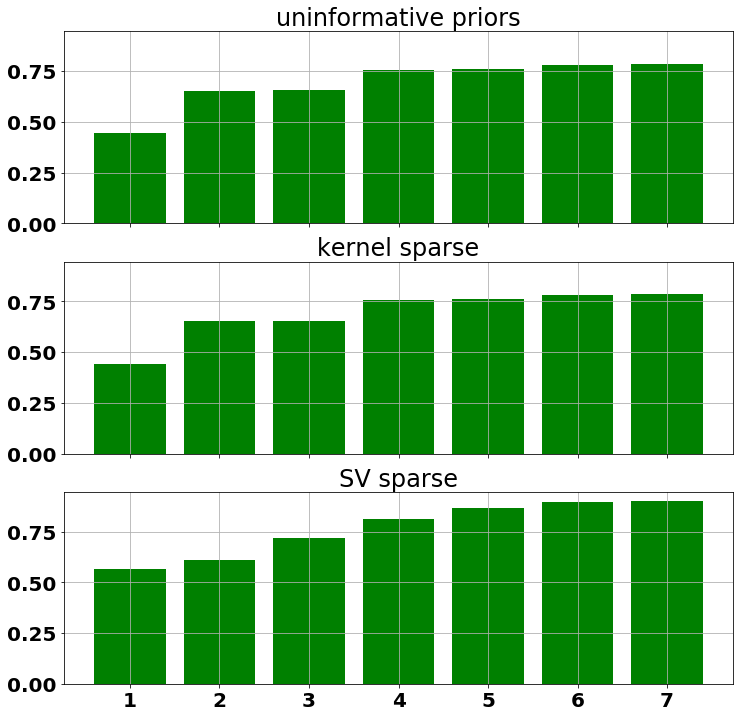

In [11]:
# plot kernel weights values e_mu 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font = {'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

f, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex=True, figsize=(12,12))
x = np.arange(1,8,1)
ax1.bar(x, np.sort(e_mu[0]), color='g')
ax1.set_title('uninformative priors')
ax1.grid()
ax2.bar(x, np.sort(e_mu[1]), color='g')
ax2.set_title('kernel sparse')
ax2.grid()
ax3.bar(x, np.sort(e_mu[2]), color='g')
ax3.set_title('SV sparse')
ax3.grid()

plt.show()
#plt.savefig('flower17_kernel.png')

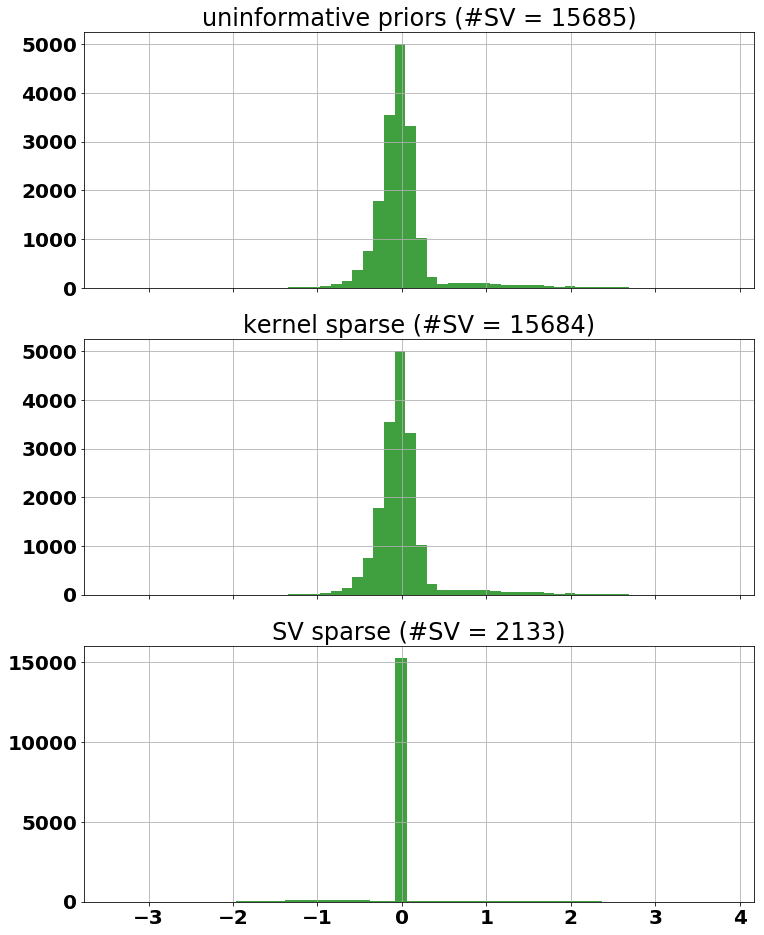

In [12]:
# ploat histogram of sample weights values a_mu
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font = {'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,16))
n, bins, patches = ax1.hist(a_mu[0].flatten(), 50, facecolor='green', alpha=0.75)
ax1.set_title('uninformative priors (#SV = %d)'% (np.abs(a_mu[0].flatten())>0.02).sum())
ax1.grid()
n, bins, patches = ax2.hist(a_mu[1].flatten(), 50, facecolor='green', alpha=0.75)
ax2.set_title('kernel sparse (#SV = %d)'% (np.abs(a_mu[1].flatten())>0.02).sum())
ax2.grid()
n, bins, patches = ax3.hist(a_mu[2].flatten(), 50,facecolor='green', alpha=0.75)
ax3.set_title('SV sparse (#SV = %d)'% (np.abs(a_mu[2].flatten())>0.02).sum())
ax3.grid()

#plt.show()
plt.savefig('flower17_SV.png')